In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.metrics import classification_report

# 1. Modelos

## 1.0. Descarga de datos

In [3]:
df_bajomuestreo = pd.read_csv("df_bajomuestreo.csv")

In [4]:
df_nobajomuestreo = pd.read_csv("df_nobajomuestreo.csv")

In [4]:
df_bajomuestreo.dtypes

Unnamed: 0              int64
step                    int64
type                   object
amount                float64
nameOrig               object
oldbalanceOrg         float64
newbalanceOrig        float64
nameDest               object
oldbalanceDest        float64
newbalanceDest        float64
isFraud                 int64
isFlaggedFraud          int64
type_num                int64
difbalanceOrig        float64
difbalanceOrig_cat      int64
comerciante             int64
difbalanceDest        float64
difbalanceDest_cat      int64
type_cat                int64
dtype: object

In [5]:
tblmod = df_bajomuestreo[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']]


In [6]:
tblmod.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Semilla

In [8]:
random.seed(12345)

## 1.1. Train y Test

In [9]:
X = tblmod.iloc[:, tblmod.columns != 'isFraud']
y = tblmod.iloc[:, tblmod.columns == 'isFraud']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Número de registros train: ", format(len(X_train),',d'))
print("Número de registros test: ", format(len(X_test), ',d'))
print("Número total de registros: ", format(len(X_train)+len(X_test), ',d'))

Número de registros train:  19,163
Número de registros test:  8,214
Número total de registros:  27,377


Porcentaje de fraude en test y en train

In [11]:
#Train
100 * (len(y_train[y_train["isFraud"] == 1]) / len(y_train))

30.06836090382508

In [12]:
#Test
100 * (len(y_test[y_test["isFraud"] == 1]) / len(y_test))

29.839298758217677

## 1.2. Técnicas de evaluación del modelo

Al tratarse de un problema de aprendizaje supervisado de clasificación binaria, las principales medidas para evaluar los modelos surgen de la matriz de confusión.
Las principales medidas que surgen de esta matriz son:

- **Accuracy** : (VP + VN) / Total
- **Sensibilidad (Recall)**: VP / (VP + FN)
- **Especificidad (Precision)**: VP / (VP + FP)
- **Curva ROC. Auc**: Área bajo la curva ROC

Debido al tipo de problema, que es la detección de fraude, nos interesa que clasifique el máximo número de 1's posible (es decir el máximo número de fraude). Por ello la medida que utilizaremos será **Sensibilidad (Recall)**, ya que mide la capacidad para detectar 1's.
No obstante, se calculan todos (incluyendo la gráfica de la **curva ROC**).

### Matriz de confusión

Se implementa una función que pinta la matriz de confusión, que se usa más adelante

In [13]:
def matriz_confusion(matriz):

    plt.figure()
    plt.imshow(matconf, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("MATRIZ DE CONFUSIÓN")
    plt.colorbar()
    clases = tblmod.isFraud.unique() 
    tick_marks = np.arange(len(clases))
    plt.xticks(np.arange(2), ('0','1'))
    plt.yticks(np.arange(2), ('0','1'))
    mval = matconf.max() / 2.

   
    for i in [0,1]:
        for j in [0,1]:
            plt.text(i, j, format(matriz[j, i], 'd'),horizontalalignment="center",color="white" if matriz[j, i] > mval else "black")
    


    plt.ylabel('Valor real')
    plt.xlabel('Predicción')



### Curva ROC

In [14]:
def plot_curva_roc(fpr_train,tpr_train,roc_auc_train,fpr_test,tpr_test,roc_auc_test):
    plt.title('Curva Roc')
    plt.plot(fpr_test, tpr_test, 'b',label='AUC test  = '+str('%0.4f'%roc_auc_test))
    plt.plot(fpr_train, tpr_train, 'g',label='AUC train = '+str('%0.4f'%roc_auc_train))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r-')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('Ratio Verdaderos Positivos')
    plt.xlabel('Ratio Falsos Positivos')
    plt.show()

## 1.3. Regresión Logística

In [15]:
from sklearn.linear_model import LogisticRegression

Definimos la función **regresion_logistica**, en la que los parámetros de entrada son:

- *X_train*
- *X_test*
- *y_train*
- *y_test*
- *c_valores*: Vector que contiene diferentes valores para *c_valores*
- *penalty_valores*: l1

Como sálida tenemos la tabla de resultados *resultados_reglog*, que contiene los resultados para cada uno de los modelos resultantes de los parámetros. 

En la función, se crea un bucle para probar diferentes parámetros de **C** y de **penalty_valores**. Sacaremos en una tabla los valores de los estadísticos *Recall*, *Precision*, *Accuracy* y *Auc*. Además sacaré la curva ROC para cada uno. Y esto a su vez estará sacado tanto para Test como para Train. Todo esto se guarda en la tabla *resultados_reglog*.

In [20]:
def regresion_logistica(X_train, X_test, y_train, y_test, c_valores, penalty_valores):
    indice = 0
    #DataFrame que tiene la tabla de resultados de los estadísticos
    resultados_reglog = pd.DataFrame(columns = ['c', 'penalty',\
                                            'Recall_train', 'Precision_train','Accuracy_train','Auc_train',\
                                            'Recall_test', 'Precision_test','Accuracy_test','Auc_test','Tiempo ejecución'])
    for c in c_valores:
        for p in penalty_valores:
            ini = datetime.datetime.now()
            print('############################')
            print('############################')
            print('          C = ',c)
            print('    penalty = ',p,)
            print('############################')
            print('############################')
            #Inicializamos vector de de recall, precision, accuracy y auc.
            recall_valores_train = []
            precision_valores_train = []
            accuracy_valores_train = []
            auc_valores_train = []
            recall_valores_test = []
            precision_valores_test = []
            accuracy_valores_test = []
            auc_valores_test = []

            #Regresión logística 
            logreg = LogisticRegression(C = c, penalty = p)
            logregfit = logreg.fit(X_train,y_train.values.ravel())
            y_pred_test = logregfit.predict(X_test)
            y_pred_train = logregfit.predict(X_train)


            #Recall train
            recall_train = recall_score(y_train,y_pred_train)
            recall_valores_train.append(recall_train)
            #Precision train        
            precision_train = precision_score(y_train, y_pred_train)
            precision_valores_train.append(precision_train)
            #Accuracy train
            accuracy_train = accuracy_score(y_train, y_pred_train)
            accuracy_valores_train.append(accuracy_train)
            #AUC train
            y_roc_train = logregfit.predict_proba(X_train)[:,1]
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_roc_train)
            roc_auc_train = auc(fpr_train,tpr_train)
            auc_valores_train.append(roc_auc_train) 

            #Recall test
            recall_test = recall_score(y_test,y_pred_test)
            recall_valores_test.append(recall_test)
            #Precision test        
            precision_test = precision_score(y_test, y_pred_test)
            precision_valores_test.append(precision_test)
            #Accuracy test
            accuracy_test = accuracy_score(y_test, y_pred_test)
            accuracy_valores_test.append(accuracy_test)
            #AUC test
            y_roc_test = logregfit.predict_proba(X_test)[:,1]
            fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_roc_test)
            roc_auc_test = auc(fpr_test,tpr_test)
            auc_valores_test.append(roc_auc_test) 


            # Guardamos los estadísticos en la tabla de resultados
            resultados_reglog.loc[indice,'Recall_train'] = np.mean(recall_valores_train)
            resultados_reglog.loc[indice, 'Precision_train'] = np.mean(precision_valores_train)
            resultados_reglog.loc[indice, 'Accuracy_train'] = np.mean(accuracy_valores_train)
            resultados_reglog.loc[indice, 'Auc_train'] = np.mean(auc_valores_train)

            resultados_reglog.loc[indice,'Recall_test'] = np.mean(recall_valores_test)
            resultados_reglog.loc[indice, 'Precision_test'] = np.mean(precision_valores_test)
            resultados_reglog.loc[indice, 'Accuracy_test'] = np.mean(accuracy_valores_test)
            resultados_reglog.loc[indice, 'Auc_test'] = np.mean(auc_valores_test)
            fin = datetime.datetime.now()
            resultados_reglog.loc[indice, 'Tiempo ejecución'] = fin-ini
            resultados_reglog.loc[indice, 'c'] = c
            resultados_reglog.loc[indice, 'penalty'] = p

            indice += 1
            #Imprimos Recall, Precision, Accuracy y Auc.
            print('')
            print('Recall = ' + str('%0.5f'%np.mean(recall_valores_test)))
            print('Precision = '+str('%0.5f'%np.mean(precision_valores_test)))
            print('Accuracy = '+str('%0.5f'%np.mean(accuracy_valores_test)))
            print('Auc = '+str('%0.5f'%np.mean(auc_valores_test)))
            print('Tiempo ejecución = '+str(fin-ini))
            print('')

            #Curva Roc para Train y Test
            plot_curva_roc(fpr_train,tpr_train,roc_auc_train,fpr_test,tpr_test,roc_auc_test)

    return resultados_reglog




    


############################
############################
          C =  0.001
    penalty =  l1
############################
############################

Recall = 0.86822
Precision = 0.89299
Accuracy = 0.92963
Auc = 0.97598
Tiempo ejecución = 0:00:01.355849



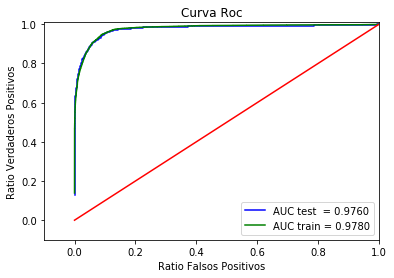

############################
############################
          C =  0.005
    penalty =  l1
############################
############################

Recall = 0.81763
Precision = 0.93166
Accuracy = 0.92768
Auc = 0.97681
Tiempo ejecución = 0:00:02.197246



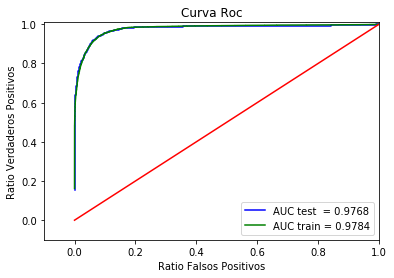

############################
############################
          C =  0.008
    penalty =  l1
############################
############################

Recall = 0.81395
Precision = 0.93662
Accuracy = 0.92805
Auc = 0.97580
Tiempo ejecución = 0:00:02.542928



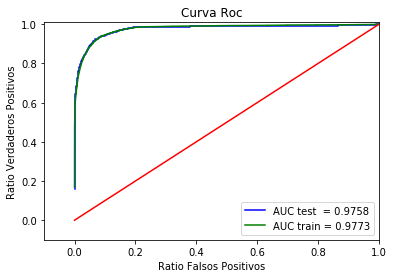

############################
############################
          C =  0.01
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93647
Accuracy = 0.92744
Auc = 0.97540
Tiempo ejecución = 0:00:02.361863



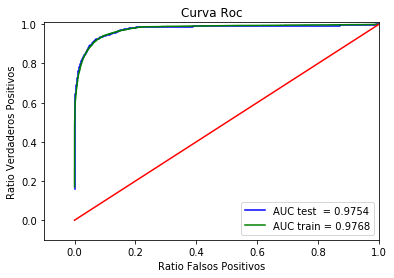

############################
############################
          C =  0.03
    penalty =  l1
############################
############################

Recall = 0.81273
Precision = 0.93697
Accuracy = 0.92781
Auc = 0.97422
Tiempo ejecución = 0:00:02.752167



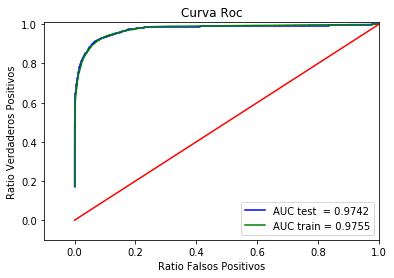

############################
############################
          C =  0.05
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93647
Accuracy = 0.92744
Auc = 0.97400
Tiempo ejecución = 0:00:02.278378



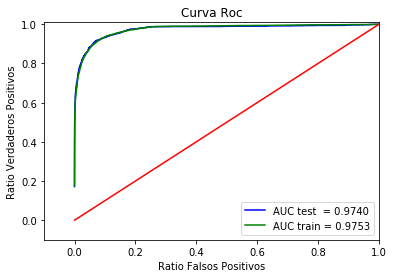

############################
############################
          C =  0.1
    penalty =  l1
############################
############################

Recall = 0.81151
Precision = 0.93644
Accuracy = 0.92732
Auc = 0.97384
Tiempo ejecución = 0:00:02.252900



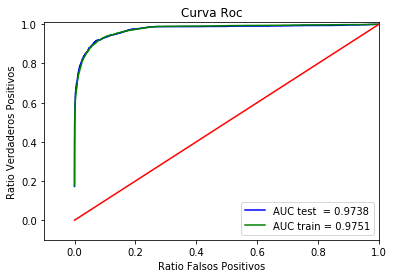

############################
############################
          C =  0.5
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97375
Tiempo ejecución = 0:00:02.419800



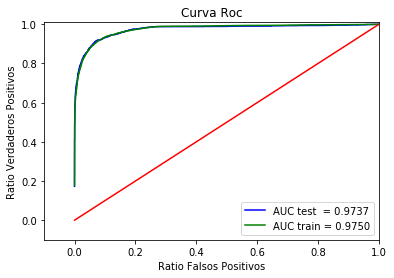

############################
############################
          C =  0.8
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97374
Tiempo ejecución = 0:00:02.387429



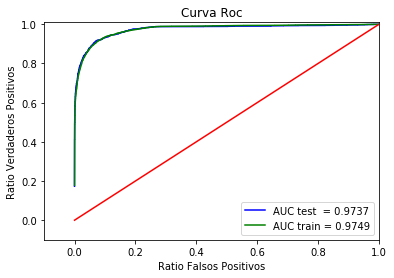

############################
############################
          C =  1
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97372
Tiempo ejecución = 0:00:02.250892



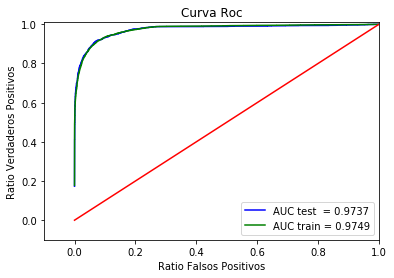

############################
############################
          C =  5
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97371
Tiempo ejecución = 0:00:02.114128



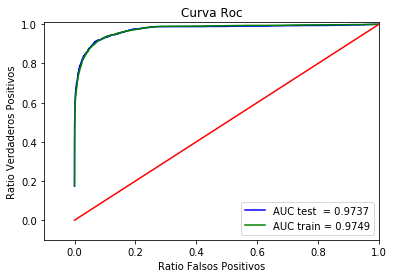

############################
############################
          C =  10
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97371
Tiempo ejecución = 0:00:02.141976



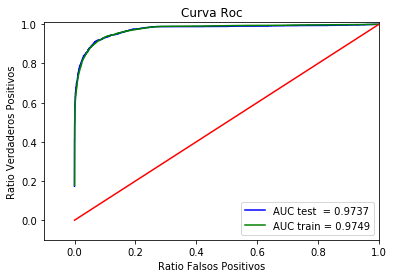

############################
############################
          C =  50
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97372
Tiempo ejecución = 0:00:02.484149



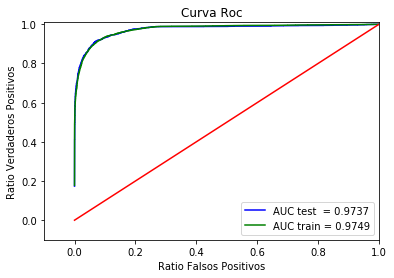

############################
############################
          C =  100
    penalty =  l1
############################
############################

Recall = 0.81191
Precision = 0.93603
Accuracy = 0.92732
Auc = 0.97372
Tiempo ejecución = 0:00:02.835529



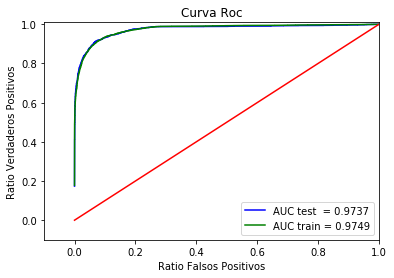

In [21]:
#Vector de parámetros c
c_valores = [0.001,0.005,0.008,0.01,0.03,0.05,0.1,0.5,0.8,1,5,10,50,100]
penalty_valores = ['l1']
resultados_reglog = regresion_logistica(X_train,X_test,y_train,y_test,c_valores,penalty_valores)

In [22]:
resultados_reglog

c penalty Recall_train Precision_train Accuracy_train Auc_train  \
0   0.001      l1     0.880597        0.886133       0.930074  0.978003   
1   0.005      l1     0.826276        0.923211       0.927099  0.978396   
2   0.008      l1     0.826623        0.926113       0.928038  0.977254   
3    0.01      l1     0.825234        0.925457       0.927464  0.976805   
4    0.03      l1     0.824019        0.924815       0.926943  0.975533   
5    0.05      l1     0.824019        0.925536       0.927151  0.975283   
6     0.1      l1     0.822978        0.924907       0.926682  0.975097   
7     0.5      l1     0.823152        0.924742       0.926682  0.974955   
8     0.8      l1     0.823152        0.924742       0.926682  0.974943   
9       1      l1     0.823152        0.924561       0.926629  0.974933   
10      5      l1     0.823152        0.924742       0.926682   0.97492   
11     10      l1     0.823152        0.924561       0.926629  0.974917   
12     50      l1     0.823325        0.924576       0.926682  0.974921   
13    100      l1     0.823325        0.924576       0.926682  0.974922   

   Recall_test Precision_test Accuracy_test  Auc_test Tiempo ejecución  
0     0.868217       0.892992      0.929632  0.975985   0:00:01.355849  
1     0.817625        0.93166      0.927684  0.976808   0:00:02.197246  
2     0.813953        0.93662       0.92805  0.975796   0:00:02.542928  
3     0.811914       0.936471      0.927441  0.975395   0:00:02.361863  
4     0.812729       0.936971      0.927806  0.974219   0:00:02.752167  
5     0.811914       0.936471      0.927441  0.974004   0:00:02.278378  
6     0.811506       0.936441      0.927319  0.973839   0:00:02.252900  
7     0.811914        0.93603      0.927319  0.973748   0:00:02.419800  
8     0.811914        0.93603      0.927319   0.97374   0:00:02.387429  
9     0.811914        0.93603      0.927319   0.97372   0:00:02.250892  
10    0.811914        0.93603      0.927319  0.973713   0:00:02.114128  
11    0.811914        0.93603      0.927319   0.97371   0:00:02.141976  
12    0.811914        0.93603      0.927319  0.973723   0:00:02.484149  
13    0.811914        0.93603      0.927319  0.973723   0:00:02.835529

### Mejor modelo de Regresión Logística

In [23]:
resultados_reglog[resultados_reglog['Recall_test'] == max(resultados_reglog['Recall_test'])]

c penalty Recall_train Precision_train Accuracy_train Auc_train  \
0  0.001      l1     0.880597        0.886133       0.930074  0.978003   

  Recall_test Precision_test Accuracy_test  Auc_test Tiempo ejecución  
0    0.868217       0.892992      0.929632  0.975985   0:00:01.355849

Aquí vemos que la mejor regresión logística es la que tiene los parámetros:

- *c = 0.001*
- *penalty = l1*

In [24]:
logreg = LogisticRegression(C = 0.001, penalty = 'l1')
logregfit = logreg.fit(X_train,y_train.values.ravel())
y_pred_test_logreg = logregfit.predict(X_test)


### Reporte de clasificación

In [25]:
print(classification_report(y_test, y_pred_test_logreg))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95      5763
          1       0.89      0.87      0.88      2451

avg / total       0.93      0.93      0.93      8214



### Matriz de confusión

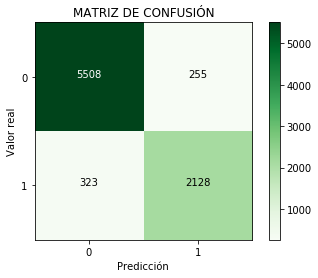

In [26]:
matconf = confusion_matrix(y_test, y_pred_test_logreg)
matriz_confusion(matconf)
plt.show()

### Curva ROC

In [27]:
y_roc_train_reglog = logregfit.predict_proba(X_train)[:,1]
fpr_train_reglog, tpr_train_reglog, thresholds_train_reglog = roc_curve(y_train,y_roc_train_reglog)
roc_auc_train_reglog = auc(fpr_train_reglog,tpr_train_reglog)
                
y_roc_test_reglog = logregfit.predict_proba(X_test)[:,1]
fpr_test_reglog, tpr_test_reglog, thresholds_test_reglog = roc_curve(y_test,y_roc_test_reglog)
roc_auc_test_reglog = auc(fpr_test_reglog,tpr_test_reglog)

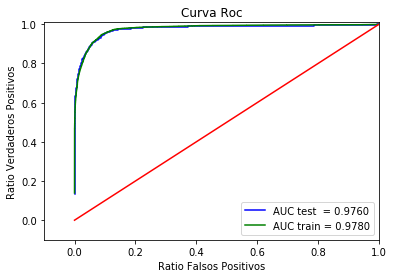

In [28]:
plot_curva_roc(fpr_train_reglog,tpr_train_reglog,roc_auc_train_reglog,fpr_test_reglog,tpr_test_reglog,roc_auc_test_reglog)

## 1.4. Árbol de decisión

In [29]:
from sklearn.tree import DecisionTreeClassifier

Definimos la función **arbol_decision**, en la que los parámetros de entrada son:

- *X_train*
- *X_test*
- *y_train*
- *y_test*
- *min_samples_leaf*: Vector que contiene diferentes valores para *min_samples_leaf*
- *max_depth*: Vector que contiene diferentes valores para *max_depth*

Como sálida tenemos la tabla de resultados *resultados_arbdec*, que contiene los resultados para cada uno de los modelos resultantes de los parámetros. 

En la función, se crea un bucle para probar diferentes parámetros de **min_samples_leaf** y **max_depth**. Sacaremos en una tabla los valores de los estadística *Recall*, *Precision*, *Accuracy* y *Auc*. Además sacaré la curva ROC para cada uno. Y esto a su vez estará sacado tanto para Test como para Train. Todo esto se guarda en la tabla **resultados_arbdec**.

In [34]:
def arbol_decision(X_train, X_test, y_train, y_test, min_samples_leaf, max_depth):
    indice = 0
    #DataFrame que tiene la tabla de resultados de los estadísticos
    resultados_arbdec = pd.DataFrame(columns = ['min_samples_leaf','max_depth', \
                                                'Recall_train', 'Precision_train','Accuracy_train','Auc_train',\
                                                'Recall_test', 'Precision_test','Accuracy_test','Auc_test','Tiempo ejecución'])

    for minsamples in min_samples_leaf:
        for maxdepth in max_depth:

            resultados_arbdec.loc[indice,'min_samples_leaf'] = minsamples
            resultados_arbdec.loc[indice,'max_depth'] = maxdepth
            ini = datetime.datetime.now()
            print('############################')
            print('############################')
            print('Min samples leaf = ',minsamples)
            print('   Max depth     = ',maxdepth)
            print('############################')
            print('############################')
            #Inicializamos vector de de recall, precision, accuracy y auc.
            recall_valores_train = []
            precision_valores_train = []
            accuracy_valores_train = []
            auc_valores_train = []
            recall_valores_test = []
            precision_valores_test = []
            accuracy_valores_test = []
            auc_valores_test = []
            #Árbol de decisión
            arbdec = DecisionTreeClassifier(min_samples_leaf = minsamples, max_depth=maxdepth)
            arbdecfit = arbdec.fit(X_train,y_train.values.ravel())
            y_pred_train = arbdecfit.predict(X_train)
            y_pred_test = arbdecfit.predict(X_test)


            
            #Recall train
            recall = recall_score(y_train,y_pred_train)
            recall_valores_train.append(recall)
            #Precision train       
            precision = precision_score(y_train, y_pred_train)
            precision_valores_train.append(precision)
            #Accuracy train
            accuracy = accuracy_score(y_train, y_pred_train)
            accuracy_valores_train.append(accuracy)
            #AUC train
            y_roc_train = arbdecfit.predict_proba(X_train)[:,1]
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_roc_train)
            roc_auc_train = auc(fpr_train,tpr_train)
            auc_valores_train.append(roc_auc_train)  


            #Recall
            recall_test = recall_score(y_test,y_pred_test)
            recall_valores_test.append(recall_test)
            #Precision        
            precision_test = precision_score(y_test, y_pred_test)
            precision_valores_test.append(precision_test)
            #Accuracy
            accuracy_test = accuracy_score(y_test, y_pred_test)
            accuracy_valores_test.append(accuracy_test)
            #AUC
            y_roc_test = arbdecfit.predict_proba(X_test)[:,1]
            fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_roc_test)
            roc_auc_test = auc(fpr_test,tpr_test)
            auc_valores_test.append(roc_auc_test)



            # Guardamos los estadísticos en la tabla de resultados
            resultados_arbdec.loc[indice,'Recall_train'] = np.mean(recall_valores_train)
            resultados_arbdec.loc[indice, 'Precision_train'] = np.mean(precision_valores_train)
            resultados_arbdec.loc[indice, 'Accuracy_train'] = np.mean(accuracy_valores_train)
            resultados_arbdec.loc[indice, 'Auc_train'] = np.mean(auc_valores_train)
            resultados_arbdec.loc[indice,'Recall_test'] = np.mean(recall_valores_test)
            resultados_arbdec.loc[indice, 'Precision_test'] = np.mean(precision_valores_test)
            resultados_arbdec.loc[indice, 'Accuracy_test'] = np.mean(accuracy_valores_test)
            resultados_arbdec.loc[indice, 'Auc_test'] = np.mean(auc_valores_test)
            fin = datetime.datetime.now()
            resultados_arbdec.loc[indice, 'Tiempo ejecución'] = fin-ini

            indice += 1
            #Imprimos Recall, Precision, Accuracy y Auc.
            print('')
            print('Recall = ' + str('%0.8f'%np.mean(recall_valores_test)))
            print('Precision = '+str('%0.8f'%np.mean(precision_valores_test)))
            print('Accuracy = '+str('%0.8f'%np.mean(accuracy_valores_test)))
            print('Auc = '+str('%0.8f'%np.mean(auc_valores_test)))
            print('Tiempo ejecución = '+str(fin-ini))
            print('')

            #Curva Roc
            plot_curva_roc(fpr_train,tpr_train,roc_auc_train,fpr_test,tpr_test,roc_auc_test)
            
    return resultados_arbdec
    
    

#best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['c']
#best_c = resultados_arbdec[resultados_arbdec['Auc'] == max(resultados_arbdec['Auc'])]['c'].values[0]
#print(results_table)    
# Finally, we can check which C parameter is the best amongst the chosen.
#print('*********************************************************************************')
#print('Best model to choose from cross validation is with C parameter = ', best_c)
#print('*********************************************************************************')
    


############################
############################
Min samples leaf =  5
   Max depth     =  2
############################
############################

Recall = 0.86046512
Precision = 0.90398628
Accuracy = 0.93109326
Auc = 0.91587759
Tiempo ejecución = 0:00:00.056860



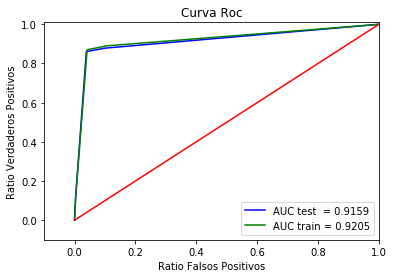

############################
############################
Min samples leaf =  5
   Max depth     =  3
############################
############################

Recall = 0.87637699
Precision = 0.91248938
Accuracy = 0.93803263
Auc = 0.96940378
Tiempo ejecución = 0:00:00.071068



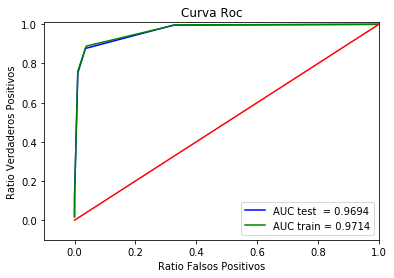

############################
############################
Min samples leaf =  5
   Max depth     =  4
############################
############################

Recall = 0.87719298
Precision = 0.95217006
Accuracy = 0.95020696
Auc = 0.98301132
Tiempo ejecución = 0:00:00.082705



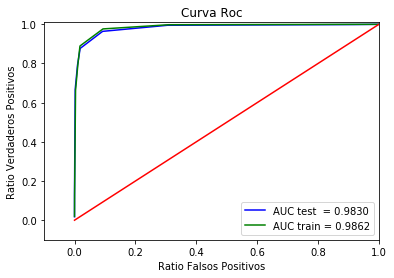

############################
############################
Min samples leaf =  5
   Max depth     =  5
############################
############################

Recall = 0.87678499
Precision = 0.96714671
Accuracy = 0.95434624
Auc = 0.99023257
Tiempo ejecución = 0:00:00.094266



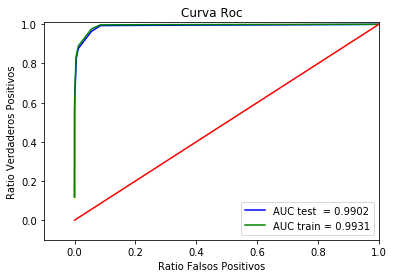

############################
############################
Min samples leaf =  5
   Max depth     =  6
############################
############################

Recall = 0.94492044
Precision = 0.94607843
Accuracy = 0.96749452
Auc = 0.99275769
Tiempo ejecución = 0:00:00.115938



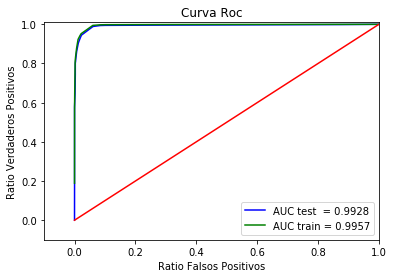

############################
############################
Min samples leaf =  5
   Max depth     =  7
############################
############################

Recall = 0.98857609
Precision = 0.93769350
Accuracy = 0.97699050
Auc = 0.99479094
Tiempo ejecución = 0:00:00.110080



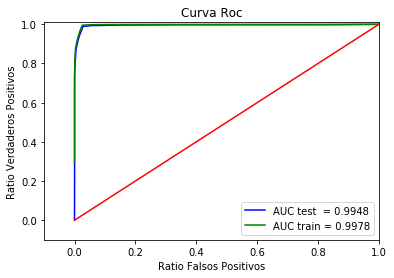

############################
############################
Min samples leaf =  5
   Max depth     =  8
############################
############################

Recall = 0.98694410
Precision = 0.93978244
Accuracy = 0.97723399
Auc = 0.99487770
Tiempo ejecución = 0:00:00.123642



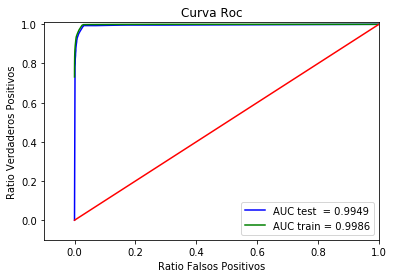

############################
############################
Min samples leaf =  5
   Max depth     =  9
############################
############################

Recall = 0.98408813
Precision = 0.97454545
Accuracy = 0.98758218
Auc = 0.99590860
Tiempo ejecución = 0:00:00.127546



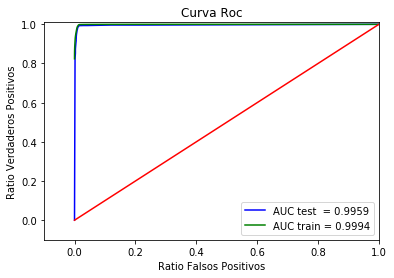

############################
############################
Min samples leaf =  10
   Max depth     =  2
############################
############################

Recall = 0.86046512
Precision = 0.90398628
Accuracy = 0.93109326
Auc = 0.91587759
Tiempo ejecución = 0:00:00.059402



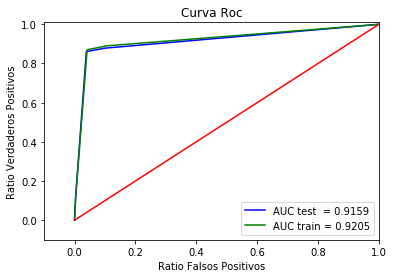

############################
############################
Min samples leaf =  10
   Max depth     =  3
############################
############################

Recall = 0.87637699
Precision = 0.91248938
Accuracy = 0.93803263
Auc = 0.96940378
Tiempo ejecución = 0:00:00.071447



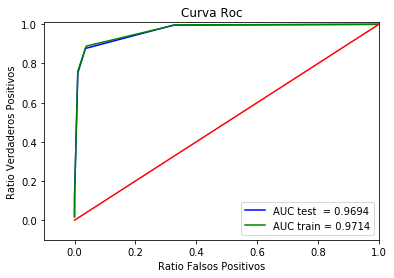

############################
############################
Min samples leaf =  10
   Max depth     =  4
############################
############################

Recall = 0.87719298
Precision = 0.95217006
Accuracy = 0.95020696
Auc = 0.98287624
Tiempo ejecución = 0:00:00.086499



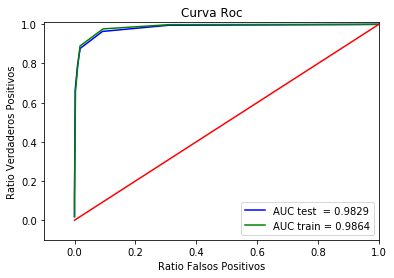

############################
############################
Min samples leaf =  10
   Max depth     =  5
############################
############################

Recall = 0.87719298
Precision = 0.96716149
Accuracy = 0.95446798
Auc = 0.99061218
Tiempo ejecución = 0:00:00.087778



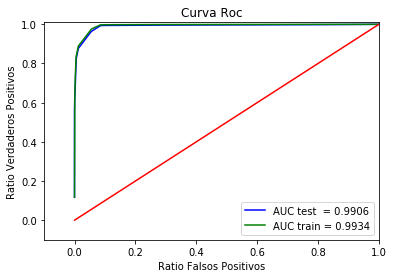

############################
############################
Min samples leaf =  10
   Max depth     =  6
############################
############################

Recall = 0.94532844
Precision = 0.94610045
Accuracy = 0.96761626
Auc = 0.99310781
Tiempo ejecución = 0:00:00.105361



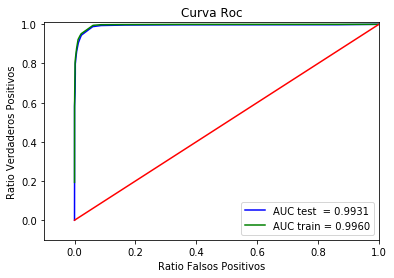

############################
############################
Min samples leaf =  10
   Max depth     =  7
############################
############################

Recall = 0.98816809
Precision = 0.93730650
Accuracy = 0.97674702
Auc = 0.99455236
Tiempo ejecución = 0:00:00.114875



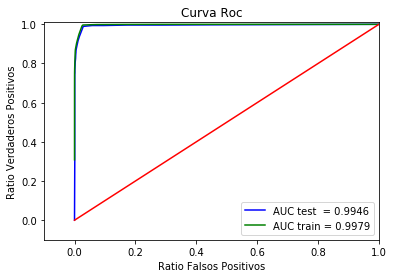

############################
############################
Min samples leaf =  10
   Max depth     =  8
############################
############################

Recall = 0.98653611
Precision = 0.93975904
Accuracy = 0.97711225
Auc = 0.99468992
Tiempo ejecución = 0:00:00.120711



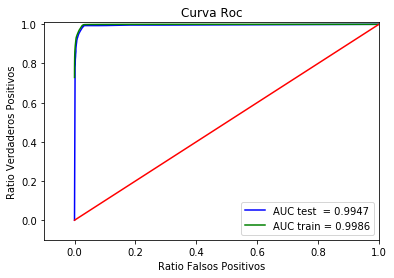

############################
############################
Min samples leaf =  10
   Max depth     =  9
############################
############################

Recall = 0.98041616
Precision = 0.97366288
Accuracy = 0.98624300
Auc = 0.99556867
Tiempo ejecución = 0:00:00.115370



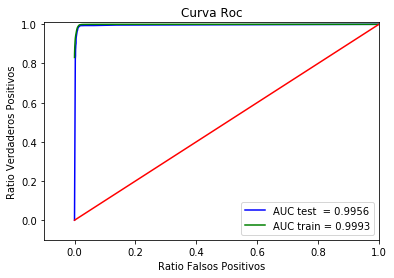

############################
############################
Min samples leaf =  30
   Max depth     =  2
############################
############################

Recall = 0.86046512
Precision = 0.90398628
Accuracy = 0.93109326
Auc = 0.91587759
Tiempo ejecución = 0:00:00.052365



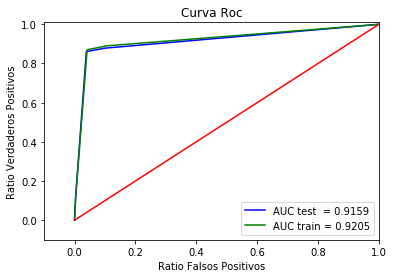

############################
############################
Min samples leaf =  30
   Max depth     =  3
############################
############################

Recall = 0.87637699
Precision = 0.91248938
Accuracy = 0.93803263
Auc = 0.96940378
Tiempo ejecución = 0:00:00.073608



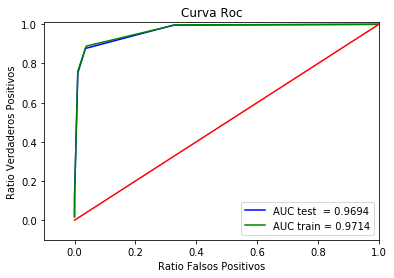

############################
############################
Min samples leaf =  30
   Max depth     =  4
############################
############################

Recall = 0.87637699
Precision = 0.95254989
Accuracy = 0.95008522
Auc = 0.98340311
Tiempo ejecución = 0:00:00.077594



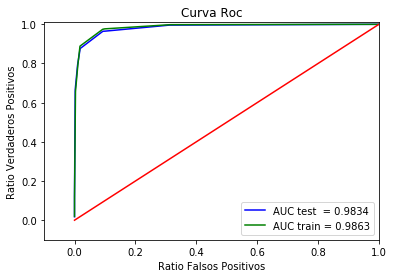

############################
############################
Min samples leaf =  30
   Max depth     =  5
############################
############################

Recall = 0.87637699
Precision = 0.96756757
Accuracy = 0.95434624
Auc = 0.99122602
Tiempo ejecución = 0:00:00.089852



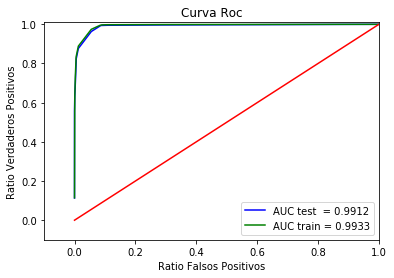

############################
############################
Min samples leaf =  30
   Max depth     =  6
############################
############################

Recall = 0.94247246
Precision = 0.94672131
Accuracy = 0.96700755
Auc = 0.99349814
Tiempo ejecución = 0:00:00.101708



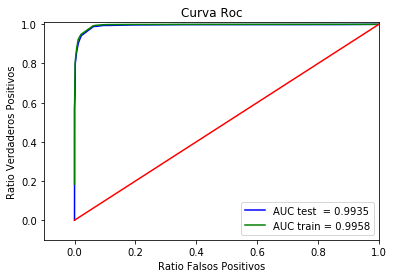

############################
############################
Min samples leaf =  30
   Max depth     =  7
############################
############################

Recall = 0.98164015
Precision = 0.94021102
Accuracy = 0.97589481
Auc = 0.99572920
Tiempo ejecución = 0:00:00.108211



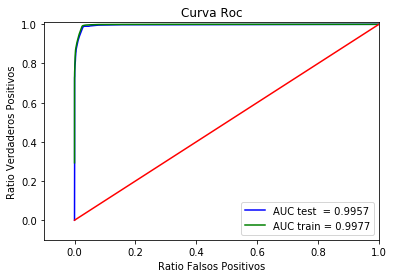

############################
############################
Min samples leaf =  30
   Max depth     =  8
############################
############################

Recall = 0.98164015
Precision = 0.94021102
Accuracy = 0.97589481
Auc = 0.99597738
Tiempo ejecución = 0:00:00.106552



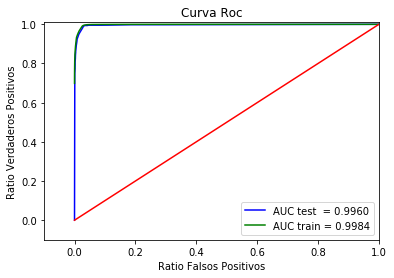

############################
############################
Min samples leaf =  30
   Max depth     =  9
############################
############################

Recall = 0.97266422
Precision = 0.97187118
Accuracy = 0.98344290
Auc = 0.99650049
Tiempo ejecución = 0:00:00.110959



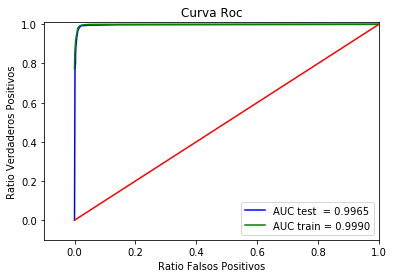

############################
############################
Min samples leaf =  50
   Max depth     =  2
############################
############################

Recall = 0.86046512
Precision = 0.90398628
Accuracy = 0.93109326
Auc = 0.91587759
Tiempo ejecución = 0:00:00.054526



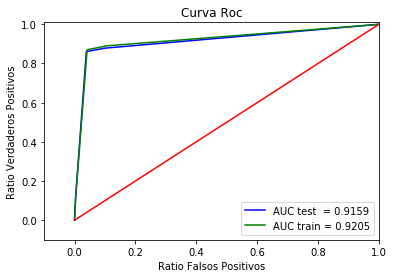

############################
############################
Min samples leaf =  50
   Max depth     =  3
############################
############################

Recall = 0.87800898
Precision = 0.90572391
Accuracy = 0.93632822
Auc = 0.96812305
Tiempo ejecución = 0:00:00.072343



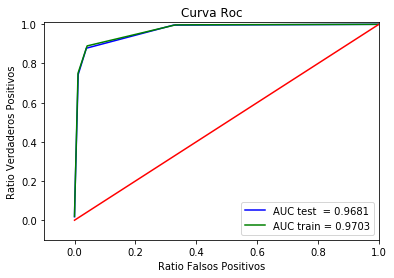

############################
############################
Min samples leaf =  50
   Max depth     =  4
############################
############################

Recall = 0.87800898
Precision = 0.94510321
Accuracy = 0.94838081
Auc = 0.98254892
Tiempo ejecución = 0:00:00.073597



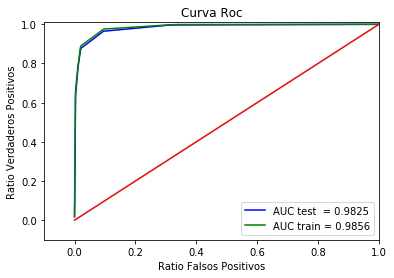

############################
############################
Min samples leaf =  50
   Max depth     =  5
############################
############################

Recall = 0.87800898
Precision = 0.95985727
Accuracy = 0.95264183
Auc = 0.99054864
Tiempo ejecución = 0:00:00.089999



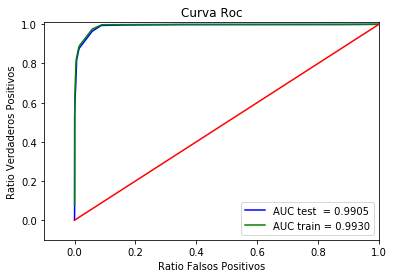

############################
############################
Min samples leaf =  50
   Max depth     =  6
############################
############################

Recall = 0.94614443
Precision = 0.93659128
Accuracy = 0.96481617
Auc = 0.99259942
Tiempo ejecución = 0:00:00.099053



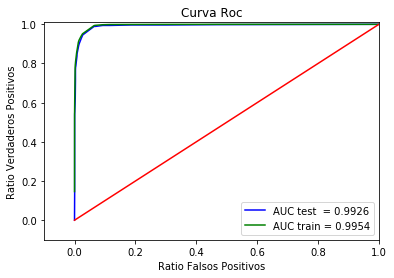

############################
############################
Min samples leaf =  50
   Max depth     =  7
############################
############################

Recall = 0.97021624
Precision = 0.93585203
Accuracy = 0.97126857
Auc = 0.99466737
Tiempo ejecución = 0:00:00.105007



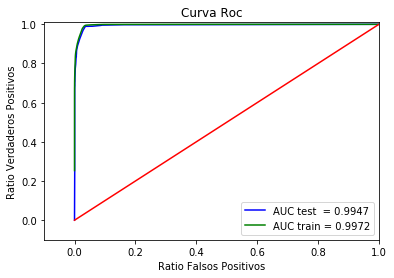

############################
############################
Min samples leaf =  50
   Max depth     =  8
############################
############################

Recall = 0.97552020
Precision = 0.93289114
Accuracy = 0.97175554
Auc = 0.99440500
Tiempo ejecución = 0:00:00.098546



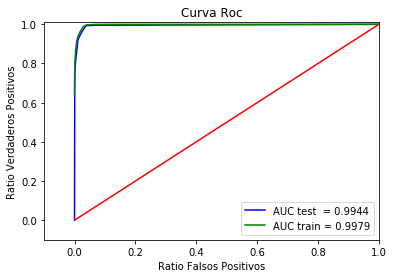

############################
############################
Min samples leaf =  50
   Max depth     =  9
############################
############################

Recall = 0.97225622
Precision = 0.95472756
Accuracy = 0.97796445
Auc = 0.99520683
Tiempo ejecución = 0:00:00.107170



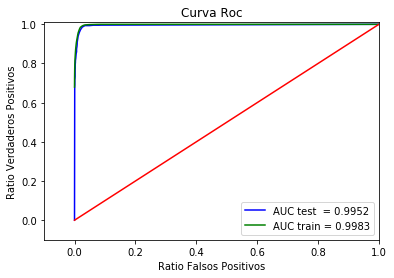

############################
############################
Min samples leaf =  100
   Max depth     =  2
############################
############################

Recall = 0.86046512
Precision = 0.90398628
Accuracy = 0.93109326
Auc = 0.91587759
Tiempo ejecución = 0:00:00.058094



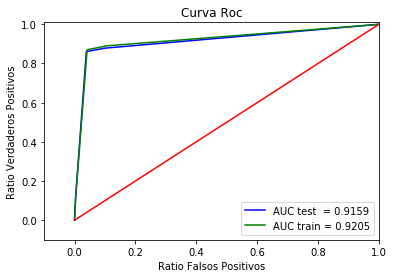

############################
############################
Min samples leaf =  100
   Max depth     =  3
############################
############################

Recall = 0.87800898
Precision = 0.90572391
Accuracy = 0.93632822
Auc = 0.96833501
Tiempo ejecución = 0:00:00.072788



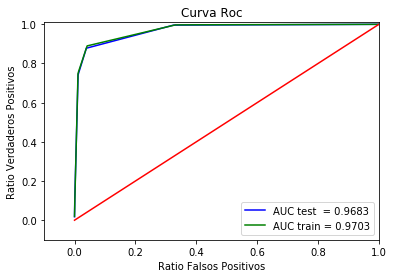

############################
############################
Min samples leaf =  100
   Max depth     =  4
############################
############################

Recall = 0.87800898
Precision = 0.94510321
Accuracy = 0.94838081
Auc = 0.98262446
Tiempo ejecución = 0:00:00.082095



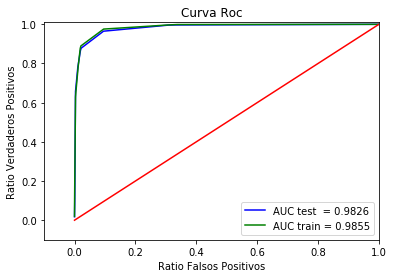

############################
############################
Min samples leaf =  100
   Max depth     =  5
############################
############################

Recall = 0.87352101
Precision = 0.95965935
Accuracy = 0.95130265
Auc = 0.99005211
Tiempo ejecución = 0:00:00.096253



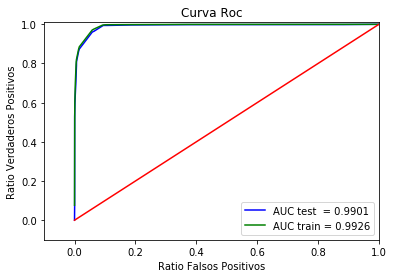

############################
############################
Min samples leaf =  100
   Max depth     =  6
############################
############################

Recall = 0.94165647
Precision = 0.93630832
Accuracy = 0.96347699
Auc = 0.99178276
Tiempo ejecución = 0:00:00.099513



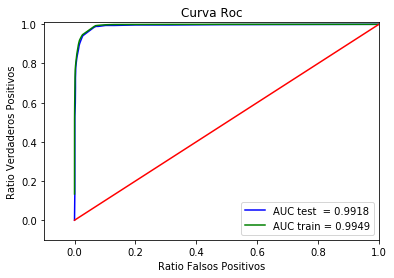

############################
############################
Min samples leaf =  100
   Max depth     =  7
############################
############################

Recall = 0.98082415
Precision = 0.91860909
Accuracy = 0.96834673
Auc = 0.99366950
Tiempo ejecución = 0:00:00.103141



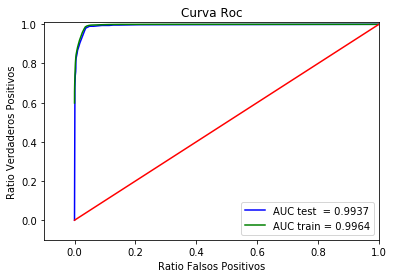

############################
############################
Min samples leaf =  100
   Max depth     =  8
############################
############################

Recall = 0.98082415
Precision = 0.91860909
Accuracy = 0.96834673
Auc = 0.99317014
Tiempo ejecución = 0:00:00.106274



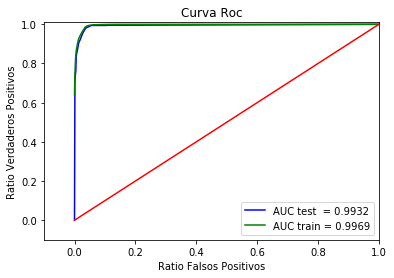

############################
############################
Min samples leaf =  100
   Max depth     =  9
############################
############################

Recall = 0.97878417
Precision = 0.93237466
Accuracy = 0.97248600
Auc = 0.99389407
Tiempo ejecución = 0:00:00.102484



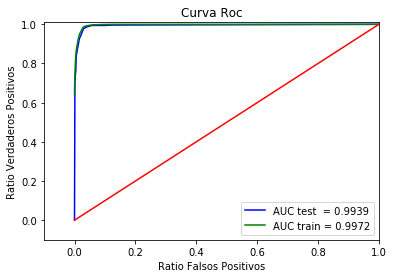

In [38]:
min_samples_leaf = [5,10,30,50,100]
max_depth = range(2,10)
resultados_arbdec = arbol_decision(X_train, X_test, y_train, y_test, min_samples_leaf, max_depth)

In [39]:
resultados_arbdec

min_samples_leaf max_depth Recall_train Precision_train Accuracy_train  \
0                 5         2     0.870184        0.900341       0.932004   
1                 5         3      0.88858         0.90893       0.939728   
2                 5         4     0.889795        0.954216       0.954026   
3                 5         5     0.890142        0.967553       0.957992   
4                 5         6     0.951926        0.949619        0.97036   
5                 5         7     0.994273          0.9446       0.980744   
6                 5         8     0.993926        0.946299       0.981214   
7                 5         9      0.98976        0.977043       0.989929   
8                10         2     0.870184        0.900341       0.932004   
9                10         3      0.88858         0.90893       0.939728   
10               10         4     0.889795        0.954216       0.954026   
11               10         5     0.889795        0.967176       0.957783   
12               10         6     0.951579        0.949273       0.970151   
13               10         7     0.993405        0.943776       0.980222   
14               10         8     0.992364        0.945593       0.980535   
15               10         9     0.986116        0.976121       0.988572   
16               30         2     0.870184        0.900341       0.932004   
17               30         3      0.88858         0.90893       0.939728   
18               30         4      0.88858        0.955046       0.953922   
19               30         5      0.88858        0.968047       0.957679   
20               30         6     0.948802        0.949957       0.969577   
21               30         7     0.988893        0.945412       0.979492   
22               30         8     0.988893        0.945412       0.979492   
23               30         9     0.981604        0.973494       0.986432   
24               50         2     0.870184        0.900341       0.932004   
25               50         3     0.889795        0.902323       0.937901   
26               50         4     0.889795        0.947689       0.952095   
27               50         5     0.889795        0.960472       0.955852   
28               50         6     0.951579        0.939674       0.967072   
29               50         7     0.981083         0.94013       0.975526   
30               50         8     0.986984        0.937212       0.976204   
31               50         9     0.984554        0.956661       0.981944   
32              100         2     0.870184        0.900341       0.932004   
33              100         3     0.889795        0.902323       0.937901   
34              100         4     0.889795        0.947689       0.952095   
35              100         5     0.885109        0.960452       0.954496   
36              100         6     0.946893        0.939556       0.965715   
37              100         7     0.986984        0.922615       0.971194   
38              100         8     0.986984        0.922615       0.971194   
39              100         9     0.985248        0.936799       0.975578   

   Auc_train Recall_test Precision_test Accuracy_test  Auc_test  \
0   0.920496    0.860465       0.903986      0.931093  0.915878   
1    0.97143    0.876377       0.912489      0.938033  0.969404   
2   0.986233    0.877193        0.95217      0.950207  0.983011   
3   0.993126    0.876785       0.967147      0.954346  0.990233   
4   0.995747     0.94492       0.946078      0.967495  0.992758   
5   0.997801    0.988576       0.937693      0.976991  0.994791   
6   0.998633    0.986944       0.939782      0.977234  0.994878   
7    0.99941    0.984088       0.974545      0.987582  0.995909   
8   0.920496    0.860465       0.903986      0.931093  0.915878   
9    0.97143    0.876377       0.912489      0.938033  0.969404   
10  0.986438    0.877193        0.95217      0.950207  0.982876   
11  0.993396    0.877193       0.967161  

### Mejor modelo de Árbol de decisión

In [40]:
resultados_arbdec[resultados_arbdec['Recall_test'] == max(resultados_arbdec['Recall_test'])]

min_samples_leaf max_depth Recall_train Precision_train Accuracy_train  \
5                5         7     0.994273          0.9446       0.980744   

  Auc_train Recall_test Precision_test Accuracy_test  Auc_test  \
5  0.997801    0.988576       0.937693      0.976991  0.994791   

  Tiempo ejecución  
5   0:00:00.110080

Aquí vemos que el mejor árbol de decisión es el que tiene los parámetros:

- *min_samples_leaf = 5*
- *max_depth = 7*

In [41]:
print("El Recall en test obtenido es: ", '%0.5f'%resultados_arbdec[resultados_arbdec['Recall_test'] == max(resultados_arbdec['Recall_test'])]['Recall_test'].values)

El Recall en test obtenido es:  0.98858


In [42]:
arbdec = DecisionTreeClassifier(min_samples_leaf = 5, max_depth=7)
arbdecfit = arbdec.fit(X_train,y_train.values.ravel())
y_pred_test_arbdec = arbdecfit.predict(X_test)

### Reporte de clasificación

In [43]:
print(classification_report(y_test, y_pred_test_arbdec))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98      5763
          1       0.94      0.99      0.96      2451

avg / total       0.98      0.98      0.98      8214



### Matriz de confusión

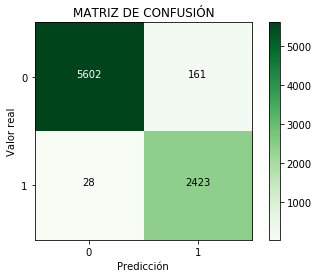

In [44]:
matconf = confusion_matrix(y_test, y_pred_test_arbdec)
matriz_confusion(matconf)
plt.show()

### Curva ROC

In [45]:
y_roc_train_arbdec = arbdecfit.predict_proba(X_train)[:,1]
fpr_train_arbdec, tpr_train_arbdec, thresholds_train_arbdec = roc_curve(y_train,y_roc_train_arbdec)
roc_auc_train_arbdec = auc(fpr_train_arbdec,tpr_train_arbdec)
                
y_roc_test_arbdec = arbdecfit.predict_proba(X_test)[:,1]
fpr_test_arbdec, tpr_test_arbdec, thresholds_test_arbdec = roc_curve(y_test,y_roc_test_arbdec)
roc_auc_test_arbdec = auc(fpr_test_arbdec,tpr_test_arbdec)


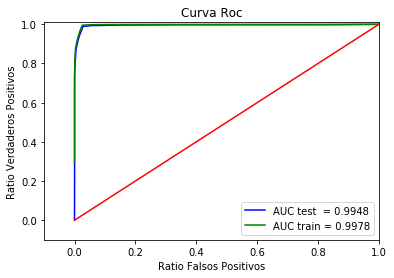

In [46]:
plot_curva_roc(fpr_train_arbdec,tpr_train_arbdec,roc_auc_train_arbdec,fpr_test_arbdec,tpr_test_arbdec,roc_auc_test_arbdec)

## 1.5. Random forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

Definimos la función **random_forest**, en la que los parámetros de entrada son:

- *X_train*
- *X_test*
- *y_train*
- *y_test*
- *min_samples_leaf*: Vector que contiene diferentes valores para *min_samples_leaf*
- *max_depth*: Vector que contiene diferentes valores para *max_depth*
- *n_estimators*: Vector que contiene diferentes valores para *n_estimators*

Como sálida tenemos la tabla de resultados *resultados_randfor*, que contiene los resultados para cada uno de los modelos resultantes de los parámetros. 

En la función, se crea un bucle para probar diferentes parámetros de **min_samples_leaf**, **max_depth** y **n_estimators**. Sacaremos en una tabla los valores de los estadística *Recall*, *Precision*, *Accuracy* y *Auc*. Además sacaré la curva ROC para cada uno. Y esto a su vez estará sacado tanto para Test como para Train. Todo esto se guarda en la tabla **resultados_randfor**.

In [48]:
def random_forest(X_train, X_test, y_train, y_test, max_depth ,min_samples_leaf, n_estimators):
    indice = 0
    #DataFrame que tiene la tabla de resultados de los estadísticos
    resultados_randfor = pd.DataFrame(columns = ['min_samples_leaf','max_depth','n_estimators', \
                                                'Recall_train', 'Precision_train','Accuracy_train','Auc_train',\
                                                'Recall_test', 'Precision_test','Accuracy_test','Auc_test','Tiempo ejecución'])

    for minsamples in min_samples_leaf:
        for maxdepth in max_depth:
            for nestimator in n_estimators:

                resultados_randfor.loc[indice,'min_samples_leaf'] = minsamples
                resultados_randfor.loc[indice,'max_depth'] = maxdepth
                resultados_randfor.loc[indice,'n_estimators'] = nestimator
                ini = datetime.datetime.now()
                print('############################')
                print('############################')
                print('Min samples leaf = ',minsamples)
                print('       Max depth = ',maxdepth)
                print('n_estimators     = ',nestimator)
                print('############################')
                print('############################')
                #Inicializamos vector de de recall, precision, accuracy y auc.
                recall_valores_train = []
                precision_valores_train = []
                accuracy_valores_train = []
                auc_valores_train = []
                recall_valores_test = []
                precision_valores_test = []
                accuracy_valores_test = []
                auc_valores_test = []
                #Random Forest 
                randfor = RandomForestClassifier(min_samples_leaf = minsamples, max_depth = maxdepth, n_estimators=nestimator)
                randforfit = randfor.fit(X_train,y_train.values.ravel())
                y_pred_train = randforfit.predict(X_train)
                y_pred_test = randforfit.predict(X_test)



                #Recall train
                recall = recall_score(y_train,y_pred_train)
                recall_valores_train.append(recall)
                #Precision train       
                precision = precision_score(y_train, y_pred_train)
                precision_valores_train.append(precision)
                #Accuracy train
                accuracy = accuracy_score(y_train, y_pred_train)
                accuracy_valores_train.append(accuracy)
                #AUC train
                y_roc_train = randforfit.predict_proba(X_train)[:,1]
                fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_roc_train)
                roc_auc_train = auc(fpr_train,tpr_train)
                auc_valores_train.append(roc_auc_train)  


                #Recall
                recall_test = recall_score(y_test,y_pred_test)
                recall_valores_test.append(recall_test)
                #Precision        
                precision_test = precision_score(y_test, y_pred_test)
                precision_valores_test.append(precision_test)
                #Accuracy
                accuracy_test = accuracy_score(y_test, y_pred_test)
                accuracy_valores_test.append(accuracy_test)
                #AUC
                y_roc_test = randforfit.predict_proba(X_test)[:,1]
                fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_roc_test)
                roc_auc_test = auc(fpr_test,tpr_test)
                auc_valores_test.append(roc_auc_test)



                # Guardamos los estadísticos en la tabla de resultados
                resultados_randfor.loc[indice,'Recall_train'] = np.mean(recall_valores_train)
                resultados_randfor.loc[indice, 'Precision_train'] = np.mean(precision_valores_train)
                resultados_randfor.loc[indice, 'Accuracy_train'] = np.mean(accuracy_valores_train)
                resultados_randfor.loc[indice, 'Auc_train'] = np.mean(auc_valores_train)
                resultados_randfor.loc[indice,'Recall_test'] = np.mean(recall_valores_test)
                resultados_randfor.loc[indice, 'Precision_test'] = np.mean(precision_valores_test)
                resultados_randfor.loc[indice, 'Accuracy_test'] = np.mean(accuracy_valores_test)
                resultados_randfor.loc[indice, 'Auc_test'] = np.mean(auc_valores_test)
                fin = datetime.datetime.now()
                resultados_randfor.loc[indice, 'Tiempo ejecución'] = fin-ini

                indice += 1
                #Imprimos Recall, Precision, Accuracy y Auc.
                print('')
                print('Recall = ' + str('%0.5f'%np.mean(recall_valores_test)))
                print('Precision = '+str('%0.5f'%np.mean(precision_valores_test)))
                print('Accuracy = '+str('%0.5f'%np.mean(accuracy_valores_test)))
                print('Auc = '+str('%0.5f'%np.mean(auc_valores_test)))
                print('Tiempo ejecución = '+str(fin-ini))
                print('')

                #Curva Roc
                plot_curva_roc(fpr_train,tpr_train,roc_auc_train,fpr_test,tpr_test,roc_auc_test)
            
    return resultados_randfor
    
    

############################
############################
Min samples leaf =  5
       Max depth =  4
n_estimators     =  10
############################
############################

Recall = 0.83395
Precision = 0.97659
Accuracy = 0.94449
Auc = 0.98274
Tiempo ejecución = 0:00:00.216397



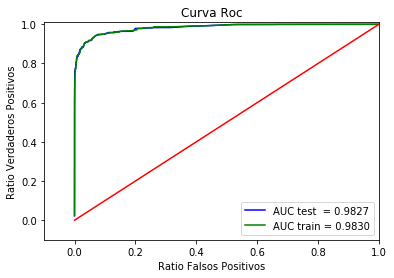

############################
############################
Min samples leaf =  5
       Max depth =  4
n_estimators     =  50
############################
############################

Recall = 0.84415
Precision = 0.97045
Accuracy = 0.94582
Auc = 0.98678
Tiempo ejecución = 0:00:00.974722



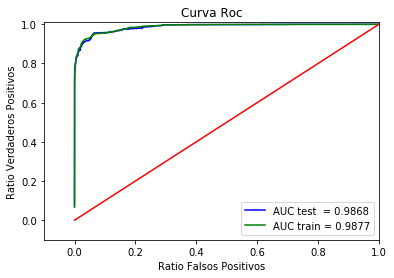

############################
############################
Min samples leaf =  5
       Max depth =  4
n_estimators     =  100
############################
############################

Recall = 0.84170
Precision = 0.97037
Accuracy = 0.94509
Auc = 0.98599
Tiempo ejecución = 0:00:01.979072



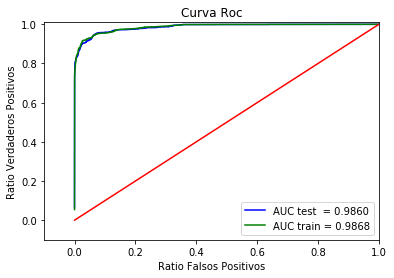

############################
############################
Min samples leaf =  5
       Max depth =  4
n_estimators     =  200
############################
############################

Recall = 0.84578
Precision = 0.97875
Accuracy = 0.94850
Auc = 0.98429
Tiempo ejecución = 0:00:03.662719



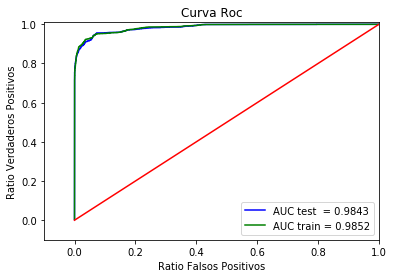

############################
############################
Min samples leaf =  5
       Max depth =  5
n_estimators     =  10
############################
############################

Recall = 0.87352
Precision = 0.96878
Accuracy = 0.95386
Auc = 0.99011
Tiempo ejecución = 0:00:00.236671



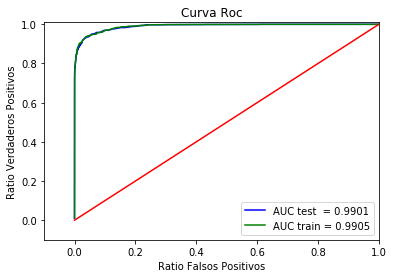

############################
############################
Min samples leaf =  5
       Max depth =  5
n_estimators     =  50
############################
############################

Recall = 0.87230
Precision = 0.97005
Accuracy = 0.95386
Auc = 0.99052
Tiempo ejecución = 0:00:01.057956



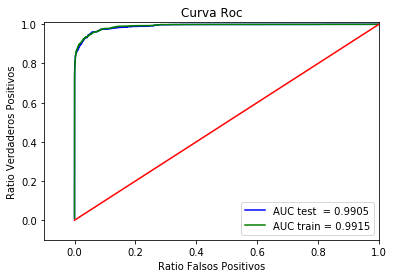

############################
############################
Min samples leaf =  5
       Max depth =  5
n_estimators     =  100
############################
############################

Recall = 0.86985
Precision = 0.97086
Accuracy = 0.95337
Auc = 0.99015
Tiempo ejecución = 0:00:02.083964



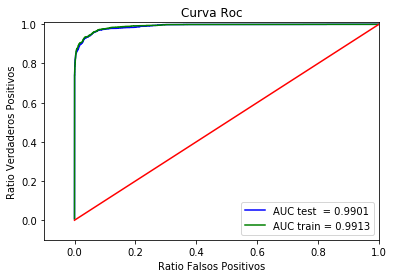

############################
############################
Min samples leaf =  5
       Max depth =  5
n_estimators     =  200
############################
############################

Recall = 0.87148
Precision = 0.97135
Accuracy = 0.95398
Auc = 0.98997
Tiempo ejecución = 0:00:04.192667



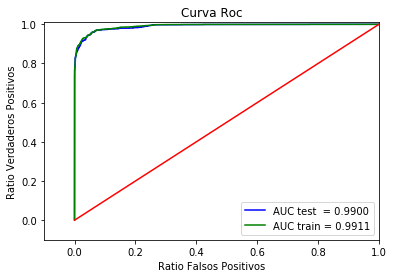

############################
############################
Min samples leaf =  5
       Max depth =  6
n_estimators     =  10
############################
############################

Recall = 0.88984
Precision = 0.97890
Accuracy = 0.96141
Auc = 0.99310
Tiempo ejecución = 0:00:00.325683



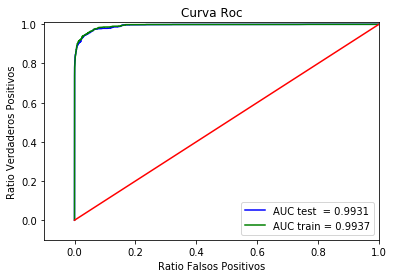

############################
############################
Min samples leaf =  5
       Max depth =  6
n_estimators     =  50
############################
############################

Recall = 0.87067
Precision = 0.98250
Accuracy = 0.95678
Auc = 0.99335
Tiempo ejecución = 0:00:01.224711



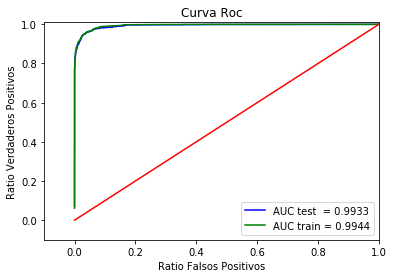

############################
############################
Min samples leaf =  5
       Max depth =  6
n_estimators     =  100
############################
############################

Recall = 0.88209
Precision = 0.97431
Accuracy = 0.95788
Auc = 0.99256
Tiempo ejecución = 0:00:02.759194



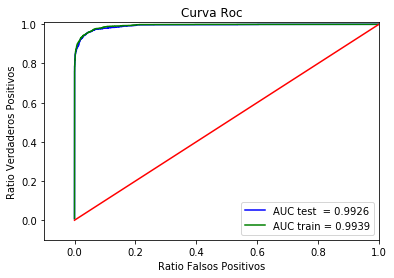

############################
############################
Min samples leaf =  5
       Max depth =  6
n_estimators     =  200
############################
############################

Recall = 0.87515
Precision = 0.97500
Accuracy = 0.95605
Auc = 0.99310
Tiempo ejecución = 0:00:05.573871



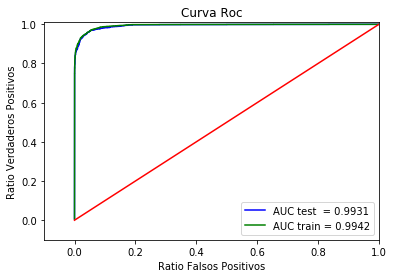

############################
############################
Min samples leaf =  5
       Max depth =  7
n_estimators     =  10
############################
############################

Recall = 0.89229
Precision = 0.97590
Accuracy = 0.96129
Auc = 0.99450
Tiempo ejecución = 0:00:00.286118



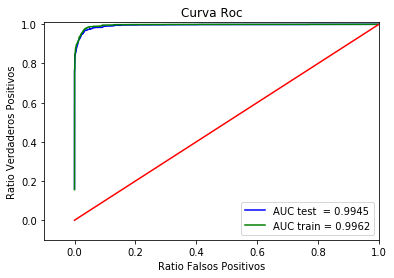

############################
############################
Min samples leaf =  5
       Max depth =  7
n_estimators     =  50
############################
############################

Recall = 0.89800
Precision = 0.97649
Accuracy = 0.96311
Auc = 0.99529
Tiempo ejecución = 0:00:01.273188



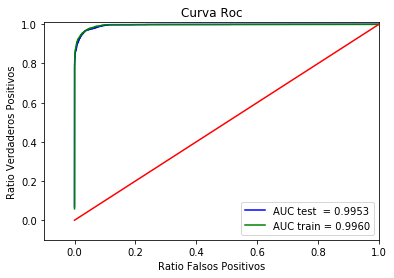

############################
############################
Min samples leaf =  5
       Max depth =  7
n_estimators     =  100
############################
############################

Recall = 0.89841
Precision = 0.97434
Accuracy = 0.96262
Auc = 0.99514
Tiempo ejecución = 0:00:02.445166



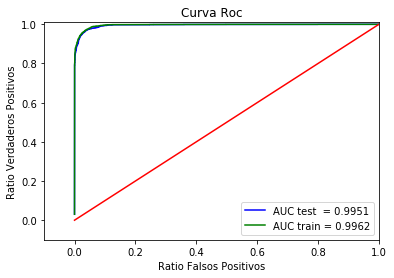

############################
############################
Min samples leaf =  5
       Max depth =  7
n_estimators     =  200
############################
############################

Recall = 0.90004
Precision = 0.97611
Accuracy = 0.96360
Auc = 0.99507
Tiempo ejecución = 0:00:05.026279



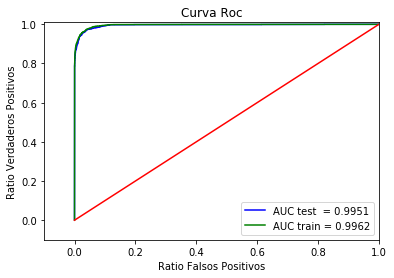

############################
############################
Min samples leaf =  5
       Max depth =  8
n_estimators     =  10
############################
############################

Recall = 0.89392
Precision = 0.98207
Accuracy = 0.96348
Auc = 0.99399
Tiempo ejecución = 0:00:00.294538



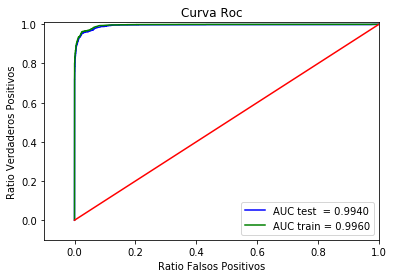

############################
############################
Min samples leaf =  5
       Max depth =  8
n_estimators     =  50
############################
############################

Recall = 0.91677
Precision = 0.97781
Accuracy = 0.96896
Auc = 0.99579
Tiempo ejecución = 0:00:01.378289



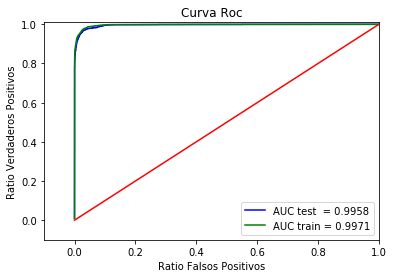

############################
############################
Min samples leaf =  5
       Max depth =  8
n_estimators     =  100
############################
############################

Recall = 0.91881
Precision = 0.98041
Accuracy = 0.97029
Auc = 0.99634
Tiempo ejecución = 0:00:02.875559



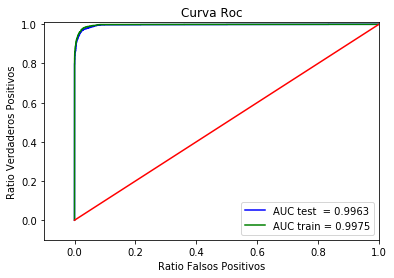

############################
############################
Min samples leaf =  5
       Max depth =  8
n_estimators     =  200
############################
############################

Recall = 0.91840
Precision = 0.97870
Accuracy = 0.96969
Auc = 0.99639
Tiempo ejecución = 0:00:05.419483



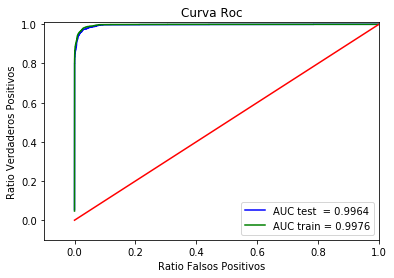

############################
############################
Min samples leaf =  5
       Max depth =  9
n_estimators     =  10
############################
############################

Recall = 0.92697
Precision = 0.97511
Accuracy = 0.97115
Auc = 0.99553
Tiempo ejecución = 0:00:00.311639



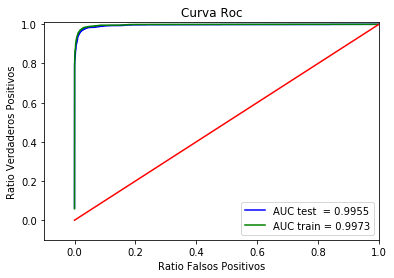

############################
############################
Min samples leaf =  5
       Max depth =  9
n_estimators     =  50
############################
############################

Recall = 0.93227
Precision = 0.97817
Accuracy = 0.97358
Auc = 0.99636
Tiempo ejecución = 0:00:01.458676



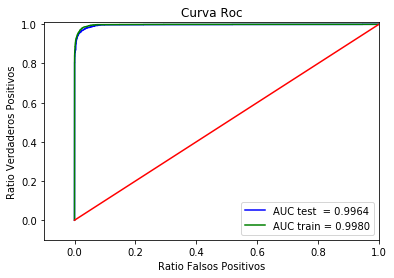

############################
############################
Min samples leaf =  5
       Max depth =  9
n_estimators     =  100
############################
############################

Recall = 0.92942
Precision = 0.97894
Accuracy = 0.97297
Auc = 0.99699
Tiempo ejecución = 0:00:02.930278



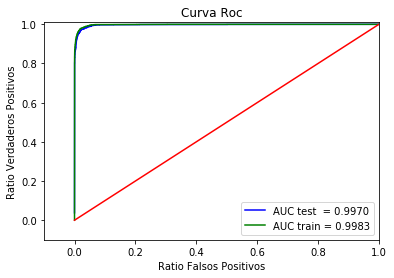

############################
############################
Min samples leaf =  5
       Max depth =  9
n_estimators     =  200
############################
############################

Recall = 0.93635
Precision = 0.97868
Accuracy = 0.97492
Auc = 0.99688
Tiempo ejecución = 0:00:05.689863



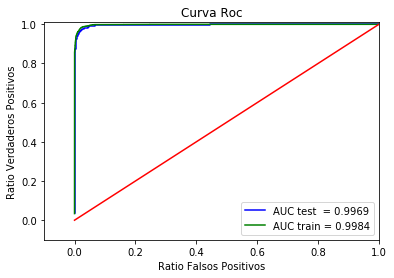

############################
############################
Min samples leaf =  10
       Max depth =  4
n_estimators     =  10
############################
############################

Recall = 0.82987
Precision = 0.98690
Accuracy = 0.94595
Auc = 0.98446
Tiempo ejecución = 0:00:00.208801



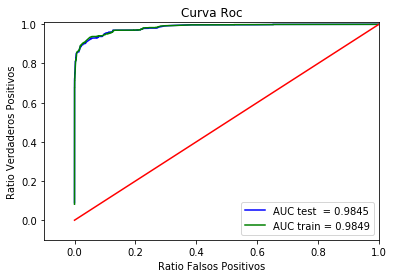

############################
############################
Min samples leaf =  10
       Max depth =  4
n_estimators     =  50
############################
############################

Recall = 0.84251
Precision = 0.97682
Accuracy = 0.94704
Auc = 0.98536
Tiempo ejecución = 0:00:00.976496



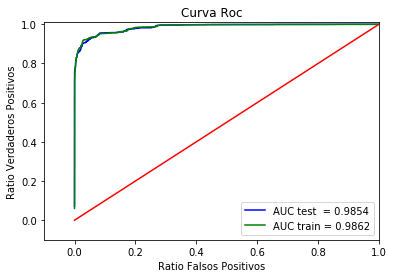

############################
############################
Min samples leaf =  10
       Max depth =  4
n_estimators     =  100
############################
############################

Recall = 0.85843
Precision = 0.96780
Accuracy = 0.94923
Auc = 0.98572
Tiempo ejecución = 0:00:01.835458



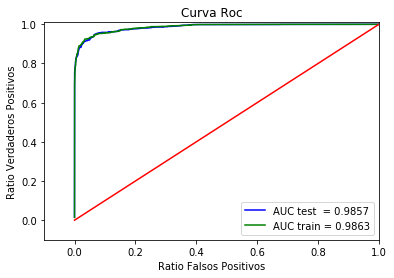

############################
############################
Min samples leaf =  10
       Max depth =  4
n_estimators     =  200
############################
############################

Recall = 0.85027
Precision = 0.97020
Accuracy = 0.94753
Auc = 0.98562
Tiempo ejecución = 0:00:03.601218



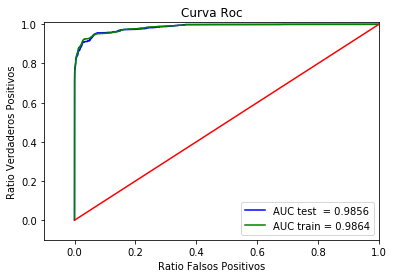

############################
############################
Min samples leaf =  10
       Max depth =  5
n_estimators     =  10
############################
############################

Recall = 0.86291
Precision = 0.98144
Accuracy = 0.95422
Auc = 0.99165
Tiempo ejecución = 0:00:00.239949



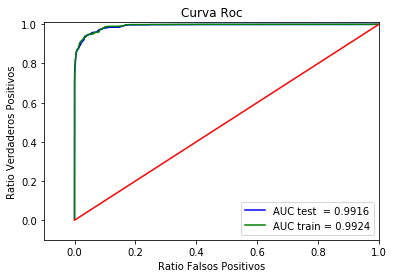

############################
############################
Min samples leaf =  10
       Max depth =  5
n_estimators     =  50
############################
############################

Recall = 0.86944
Precision = 0.97084
Accuracy = 0.95325
Auc = 0.98828
Tiempo ejecución = 0:00:01.031454



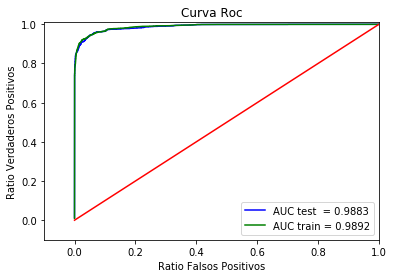

############################
############################
Min samples leaf =  10
       Max depth =  5
n_estimators     =  100
############################
############################

Recall = 0.86781
Precision = 0.96990
Accuracy = 0.95252
Auc = 0.98934
Tiempo ejecución = 0:00:02.093649



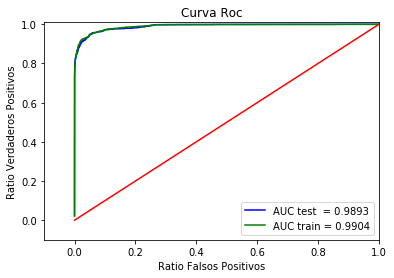

############################
############################
Min samples leaf =  10
       Max depth =  5
n_estimators     =  200
############################
############################

Recall = 0.86699
Precision = 0.97388
Accuracy = 0.95337
Auc = 0.99036
Tiempo ejecución = 0:00:04.284825



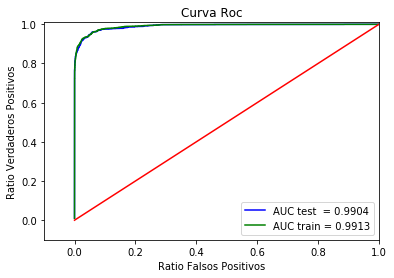

############################
############################
Min samples leaf =  10
       Max depth =  6
n_estimators     =  10
############################
############################

Recall = 0.86577
Precision = 0.97384
Accuracy = 0.95301
Auc = 0.98693
Tiempo ejecución = 0:00:00.279701



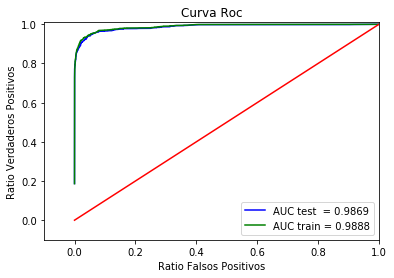

############################
############################
Min samples leaf =  10
       Max depth =  6
n_estimators     =  50
############################
############################

Recall = 0.88250
Precision = 0.97345
Accuracy = 0.95776
Auc = 0.99232
Tiempo ejecución = 0:00:01.261777



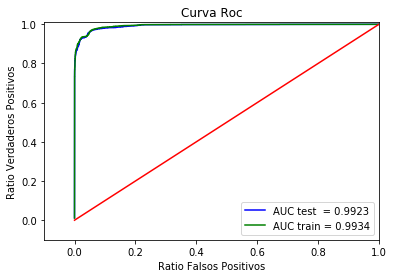

############################
############################
Min samples leaf =  10
       Max depth =  6
n_estimators     =  100
############################
############################

Recall = 0.88576
Precision = 0.97093
Accuracy = 0.95800
Auc = 0.99268
Tiempo ejecución = 0:00:02.277229



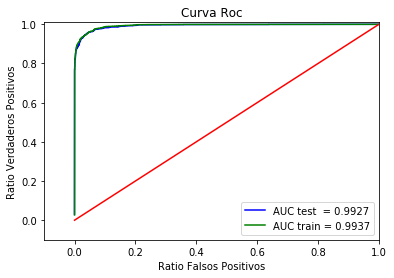

############################
############################
Min samples leaf =  10
       Max depth =  6
n_estimators     =  200
############################
############################

Recall = 0.88046
Precision = 0.97427
Accuracy = 0.95739
Auc = 0.99273
Tiempo ejecución = 0:00:04.609501



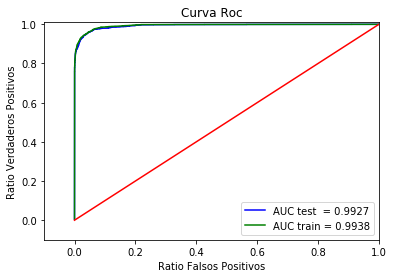

############################
############################
Min samples leaf =  10
       Max depth =  7
n_estimators     =  10
############################
############################

Recall = 0.91922
Precision = 0.96862
Accuracy = 0.96701
Auc = 0.99396
Tiempo ejecución = 0:00:00.290818



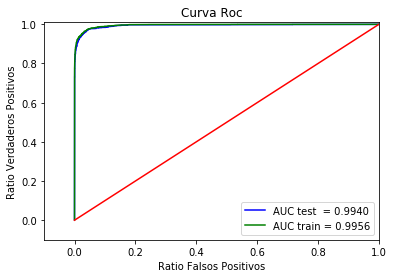

############################
############################
Min samples leaf =  10
       Max depth =  7
n_estimators     =  50
############################
############################

Recall = 0.89800
Precision = 0.97432
Accuracy = 0.96250
Auc = 0.99410
Tiempo ejecución = 0:00:01.264182



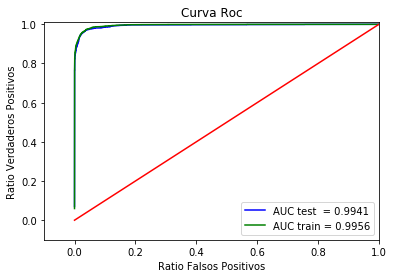

############################
############################
Min samples leaf =  10
       Max depth =  7
n_estimators     =  100
############################
############################

Recall = 0.88617
Precision = 0.97662
Accuracy = 0.95970
Auc = 0.99451
Tiempo ejecución = 0:00:02.580041



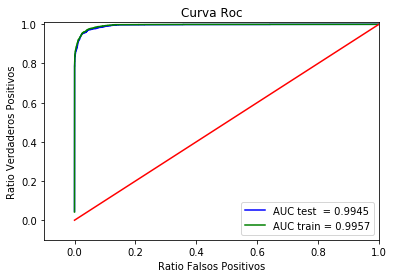

############################
############################
Min samples leaf =  10
       Max depth =  7
n_estimators     =  200
############################
############################

Recall = 0.89514
Precision = 0.97990
Accuracy = 0.96323
Auc = 0.99479
Tiempo ejecución = 0:00:05.166892



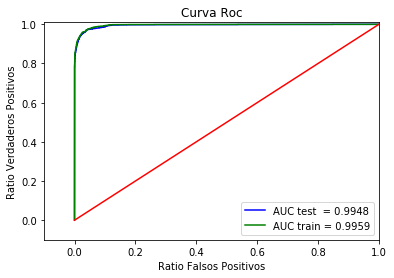

############################
############################
Min samples leaf =  10
       Max depth =  8
n_estimators     =  10
############################
############################

Recall = 0.90698
Precision = 0.98276
Accuracy = 0.96749
Auc = 0.99684
Tiempo ejecución = 0:00:00.306697



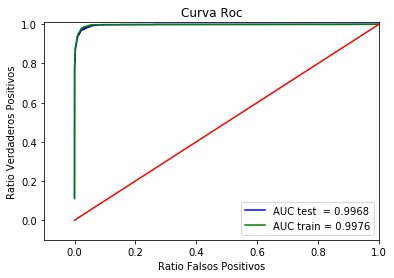

############################
############################
Min samples leaf =  10
       Max depth =  8
n_estimators     =  50
############################
############################

Recall = 0.91065
Precision = 0.97681
Accuracy = 0.96689
Auc = 0.99612
Tiempo ejecución = 0:00:01.337277



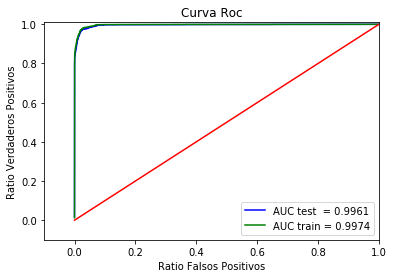

############################
############################
Min samples leaf =  10
       Max depth =  8
n_estimators     =  100
############################
############################

Recall = 0.91799
Precision = 0.97826
Accuracy = 0.96944
Auc = 0.99619
Tiempo ejecución = 0:00:02.593831



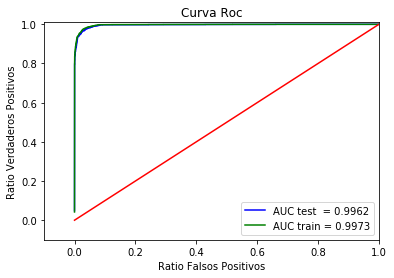

############################
############################
Min samples leaf =  10
       Max depth =  8
n_estimators     =  200
############################
############################

Recall = 0.91962
Precision = 0.97957
Accuracy = 0.97029
Auc = 0.99587
Tiempo ejecución = 0:00:05.988029



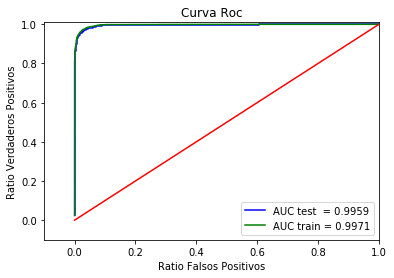

############################
############################
Min samples leaf =  10
       Max depth =  9
n_estimators     =  10
############################
############################

Recall = 0.92574
Precision = 0.97928
Accuracy = 0.97200
Auc = 0.99627
Tiempo ejecución = 0:00:00.312887



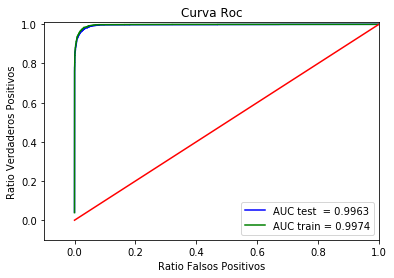

############################
############################
Min samples leaf =  10
       Max depth =  9
n_estimators     =  50
############################
############################

Recall = 0.94125
Precision = 0.97671
Accuracy = 0.97577
Auc = 0.99691
Tiempo ejecución = 0:00:01.460773



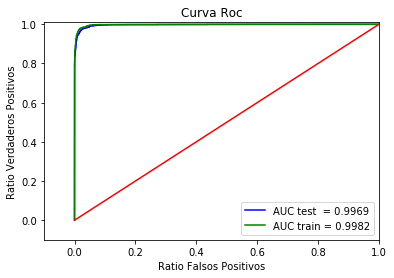

############################
############################
Min samples leaf =  10
       Max depth =  9
n_estimators     =  100
############################
############################

Recall = 0.93594
Precision = 0.97659
Accuracy = 0.97419
Auc = 0.99653
Tiempo ejecución = 0:00:02.936162



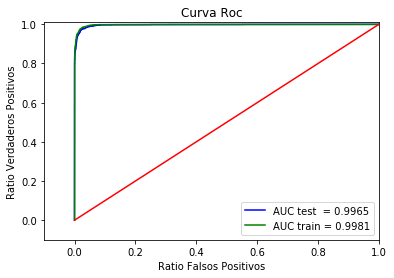

############################
############################
Min samples leaf =  10
       Max depth =  9
n_estimators     =  200
############################
############################

Recall = 0.93962
Precision = 0.97875
Accuracy = 0.97589
Auc = 0.99667
Tiempo ejecución = 0:00:05.527009



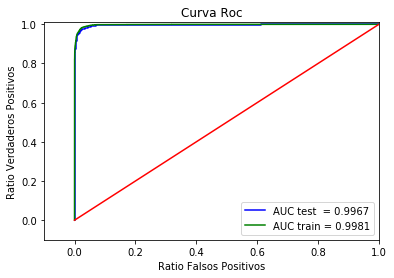

############################
############################
Min samples leaf =  20
       Max depth =  4
n_estimators     =  10
############################
############################

Recall = 0.86047
Precision = 0.96257
Accuracy = 0.94838
Auc = 0.98685
Tiempo ejecución = 0:00:00.208493



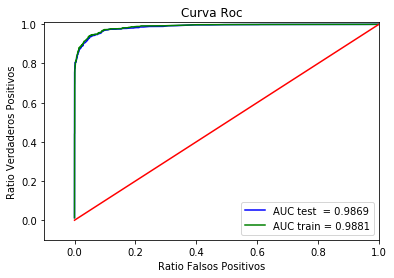

############################
############################
Min samples leaf =  20
       Max depth =  4
n_estimators     =  50
############################
############################

Recall = 0.84251
Precision = 0.97544
Accuracy = 0.94668
Auc = 0.98669
Tiempo ejecución = 0:00:00.934399



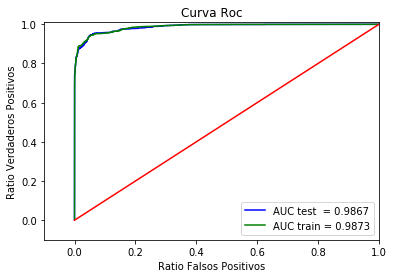

############################
############################
Min samples leaf =  20
       Max depth =  4
n_estimators     =  100
############################
############################

Recall = 0.84496
Precision = 0.96640
Accuracy = 0.94497
Auc = 0.98600
Tiempo ejecución = 0:00:01.782067



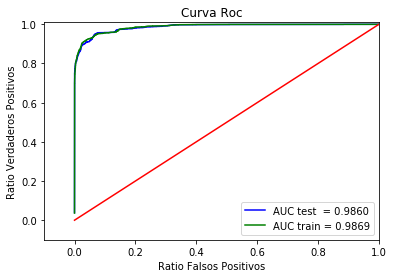

############################
############################
Min samples leaf =  20
       Max depth =  4
n_estimators     =  200
############################
############################

Recall = 0.84374
Precision = 0.97226
Accuracy = 0.94619
Auc = 0.98589
Tiempo ejecución = 0:00:03.550937



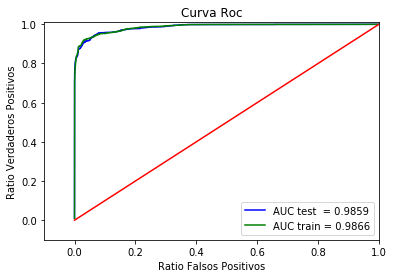

############################
############################
Min samples leaf =  20
       Max depth =  5
n_estimators     =  10
############################
############################

Recall = 0.84619
Precision = 0.98527
Accuracy = 0.95033
Auc = 0.98893
Tiempo ejecución = 0:00:00.239223



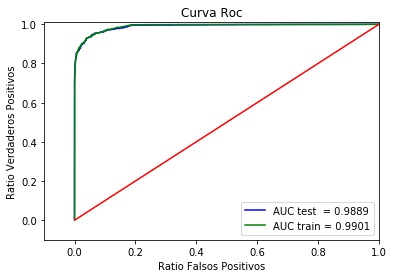

############################
############################
Min samples leaf =  20
       Max depth =  5
n_estimators     =  50
############################
############################

Recall = 0.86128
Precision = 0.97958
Accuracy = 0.95325
Auc = 0.99021
Tiempo ejecución = 0:00:01.023246



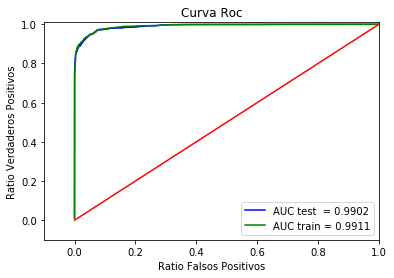

############################
############################
Min samples leaf =  20
       Max depth =  5
n_estimators     =  100
############################
############################

Recall = 0.86006
Precision = 0.98275
Accuracy = 0.95374
Auc = 0.98812
Tiempo ejecución = 0:00:02.084047



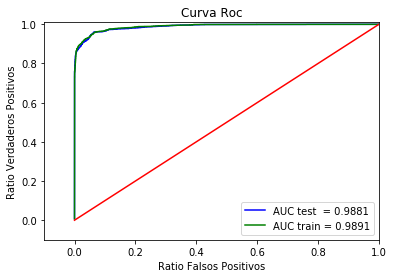

############################
############################
Min samples leaf =  20
       Max depth =  5
n_estimators     =  200
############################
############################

Recall = 0.86822
Precision = 0.97080
Accuracy = 0.95289
Auc = 0.99006
Tiempo ejecución = 0:00:04.113406



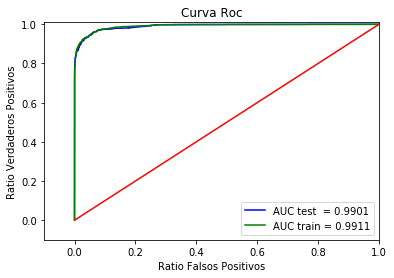

############################
############################
Min samples leaf =  20
       Max depth =  6
n_estimators     =  10
############################
############################

Recall = 0.87842
Precision = 0.97157
Accuracy = 0.95605
Auc = 0.99203
Tiempo ejecución = 0:00:00.261789



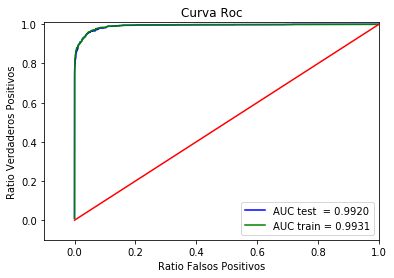

############################
############################
Min samples leaf =  20
       Max depth =  6
n_estimators     =  50
############################
############################

Recall = 0.87026
Precision = 0.97442
Accuracy = 0.95447
Auc = 0.99251
Tiempo ejecución = 0:00:01.167396



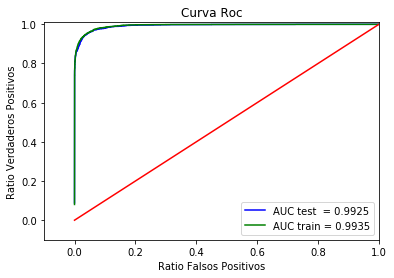

############################
############################
Min samples leaf =  20
       Max depth =  6
n_estimators     =  100
############################
############################

Recall = 0.88127
Precision = 0.97253
Accuracy = 0.95715
Auc = 0.99208
Tiempo ejecución = 0:00:02.421885



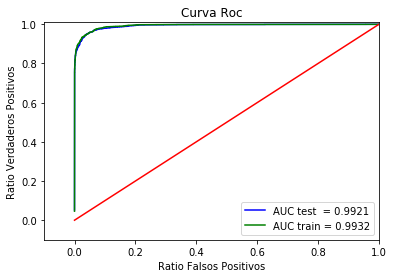

############################
############################
Min samples leaf =  20
       Max depth =  6
n_estimators     =  200
############################
############################

Recall = 0.88168
Precision = 0.97518
Accuracy = 0.95800
Auc = 0.99208
Tiempo ejecución = 0:00:04.842214



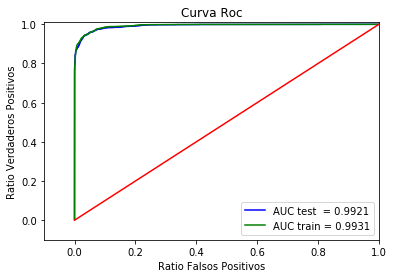

############################
############################
Min samples leaf =  20
       Max depth =  7
n_estimators     =  10
############################
############################

Recall = 0.88576
Precision = 0.97442
Accuracy = 0.95897
Auc = 0.99330
Tiempo ejecución = 0:00:00.340733



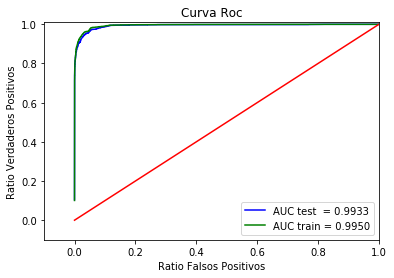

############################
############################
Min samples leaf =  20
       Max depth =  7
n_estimators     =  50
############################
############################

Recall = 0.89800
Precision = 0.97303
Accuracy = 0.96214
Auc = 0.99374
Tiempo ejecución = 0:00:01.418083



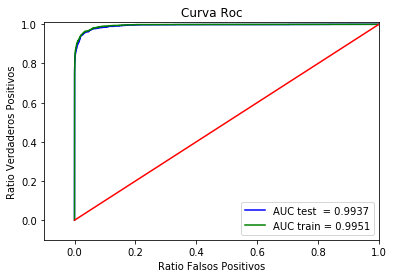

############################
############################
Min samples leaf =  20
       Max depth =  7
n_estimators     =  100
############################
############################

Recall = 0.89596
Precision = 0.97427
Accuracy = 0.96189
Auc = 0.99464
Tiempo ejecución = 0:00:03.369360



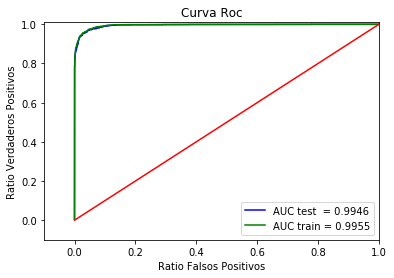

############################
############################
Min samples leaf =  20
       Max depth =  7
n_estimators     =  200
############################
############################

Recall = 0.89596
Precision = 0.97297
Accuracy = 0.96153
Auc = 0.99437
Tiempo ejecución = 0:00:06.515714



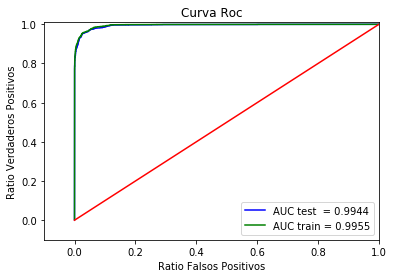

############################
############################
Min samples leaf =  20
       Max depth =  8
n_estimators     =  10
############################
############################

Recall = 0.91473
Precision = 0.97014
Accuracy = 0.96616
Auc = 0.99412
Tiempo ejecución = 0:00:00.355797



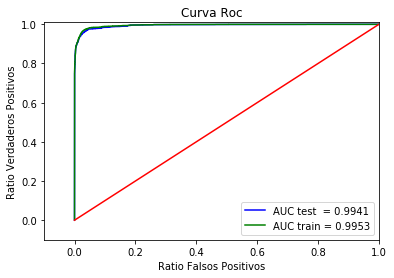

############################
############################
Min samples leaf =  20
       Max depth =  8
n_estimators     =  50
############################
############################

Recall = 0.91718
Precision = 0.97654
Accuracy = 0.96871
Auc = 0.99553
Tiempo ejecución = 0:00:01.666347



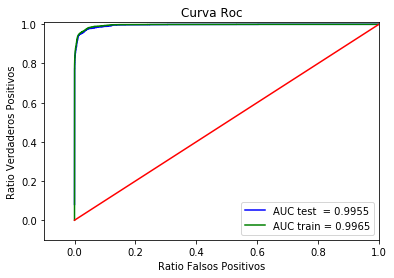

############################
############################
Min samples leaf =  20
       Max depth =  8
n_estimators     =  100
############################
############################

Recall = 0.91065
Precision = 0.97895
Accuracy = 0.96749
Auc = 0.99579
Tiempo ejecución = 0:00:03.942856



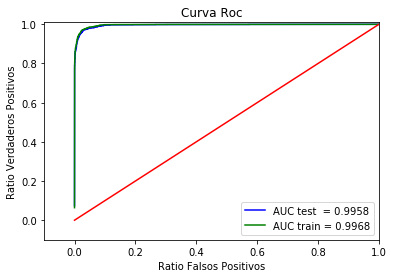

############################
############################
Min samples leaf =  20
       Max depth =  8
n_estimators     =  200
############################
############################

Recall = 0.91310
Precision = 0.97516
Accuracy = 0.96713
Auc = 0.99570
Tiempo ejecución = 0:00:07.027899



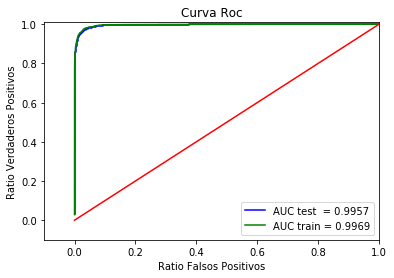

############################
############################
Min samples leaf =  20
       Max depth =  9
n_estimators     =  10
############################
############################

Recall = 0.94002
Precision = 0.97297
Accuracy = 0.97431
Auc = 0.99579
Tiempo ejecución = 0:00:00.350244



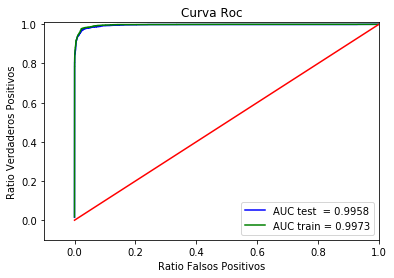

############################
############################
Min samples leaf =  20
       Max depth =  9
n_estimators     =  50
############################
############################

Recall = 0.94084
Precision = 0.97177
Accuracy = 0.97419
Auc = 0.99610
Tiempo ejecución = 0:00:01.556330



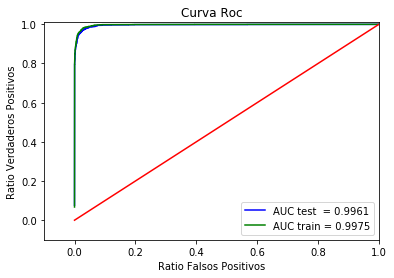

############################
############################
Min samples leaf =  20
       Max depth =  9
n_estimators     =  100
############################
############################

Recall = 0.93635
Precision = 0.97743
Accuracy = 0.97456
Auc = 0.99620
Tiempo ejecución = 0:00:03.007302



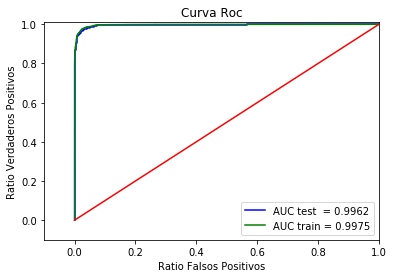

############################
############################
Min samples leaf =  20
       Max depth =  9
n_estimators     =  200
############################
############################

Recall = 0.93268
Precision = 0.97776
Accuracy = 0.97358
Auc = 0.99635
Tiempo ejecución = 0:00:05.872526



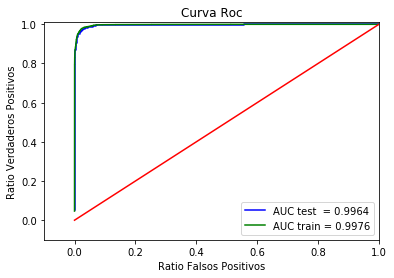

############################
############################
Min samples leaf =  30
       Max depth =  4
n_estimators     =  10
############################
############################

Recall = 0.85149
Precision = 0.96531
Accuracy = 0.94655
Auc = 0.98498
Tiempo ejecución = 0:00:00.211447



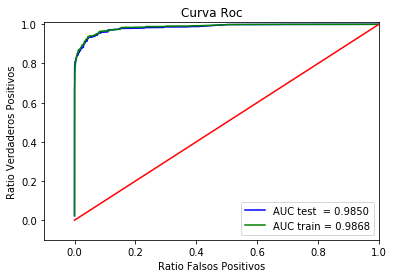

############################
############################
Min samples leaf =  30
       Max depth =  4
n_estimators     =  50
############################
############################

Recall = 0.85067
Precision = 0.96887
Accuracy = 0.94729
Auc = 0.98560
Tiempo ejecución = 0:00:00.926614



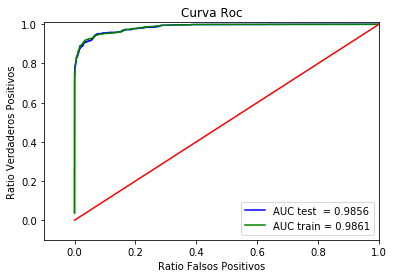

############################
############################
Min samples leaf =  30
       Max depth =  4
n_estimators     =  100
############################
############################

Recall = 0.86332
Precision = 0.96182
Accuracy = 0.94899
Auc = 0.98626
Tiempo ejecución = 0:00:01.827956



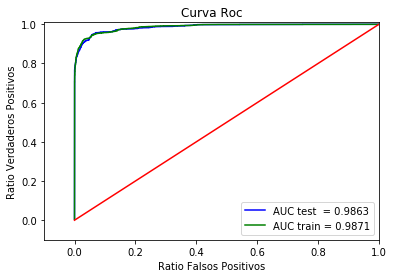

############################
############################
Min samples leaf =  30
       Max depth =  4
n_estimators     =  200
############################
############################

Recall = 0.84619
Precision = 0.97325
Accuracy = 0.94716
Auc = 0.98525
Tiempo ejecución = 0:00:03.605060



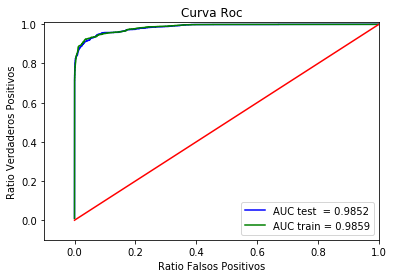

############################
############################
Min samples leaf =  30
       Max depth =  5
n_estimators     =  10
############################
############################

Recall = 0.86373
Precision = 0.97333
Accuracy = 0.95228
Auc = 0.98942
Tiempo ejecución = 0:00:00.223199



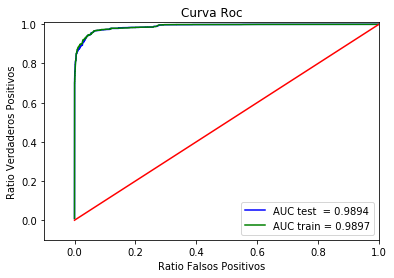

############################
############################
Min samples leaf =  30
       Max depth =  5
n_estimators     =  50
############################
############################

Recall = 0.86781
Precision = 0.97479
Accuracy = 0.95386
Auc = 0.98955
Tiempo ejecución = 0:00:01.055908



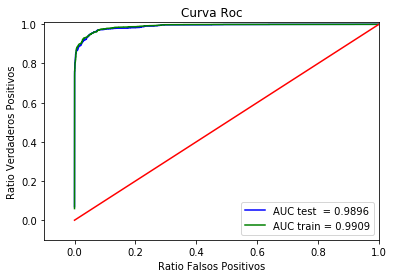

############################
############################
Min samples leaf =  30
       Max depth =  5
n_estimators     =  100
############################
############################

Recall = 0.86985
Precision = 0.96865
Accuracy = 0.95276
Auc = 0.98984
Tiempo ejecución = 0:00:02.063502



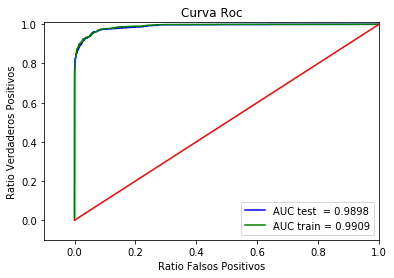

############################
############################
Min samples leaf =  30
       Max depth =  5
n_estimators     =  200
############################
############################

Recall = 0.87026
Precision = 0.97131
Accuracy = 0.95362
Auc = 0.98991
Tiempo ejecución = 0:00:04.111188



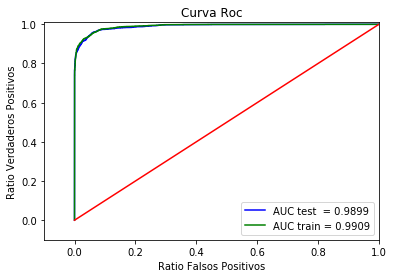

############################
############################
Min samples leaf =  30
       Max depth =  6
n_estimators     =  10
############################
############################

Recall = 0.88086
Precision = 0.96903
Accuracy = 0.95605
Auc = 0.98928
Tiempo ejecución = 0:00:00.264577



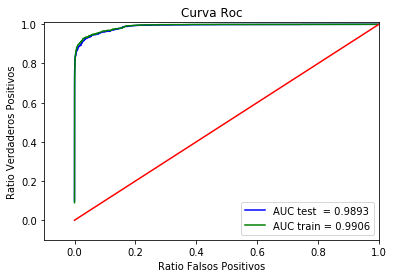

############################
############################
Min samples leaf =  30
       Max depth =  6
n_estimators     =  50
############################
############################

Recall = 0.89270
Precision = 0.96600
Accuracy = 0.95861
Auc = 0.99315
Tiempo ejecución = 0:00:01.129513



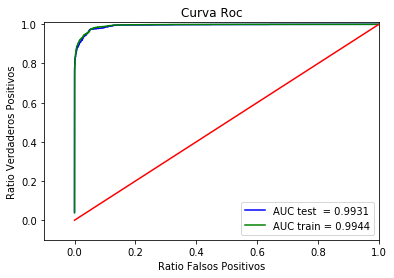

############################
############################
Min samples leaf =  30
       Max depth =  6
n_estimators     =  100
############################
############################

Recall = 0.87515
Precision = 0.97544
Accuracy = 0.95617
Auc = 0.99285
Tiempo ejecución = 0:00:02.320341



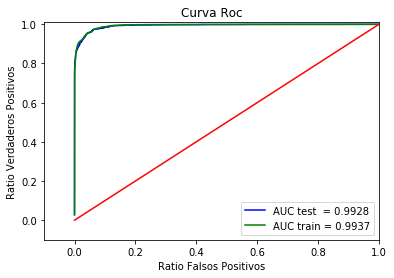

############################
############################
Min samples leaf =  30
       Max depth =  6
n_estimators     =  200
############################
############################

Recall = 0.88494
Precision = 0.97177
Accuracy = 0.95800
Auc = 0.99202
Tiempo ejecución = 0:00:04.866433



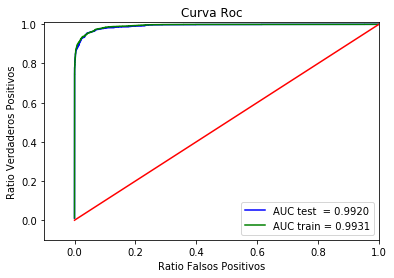

############################
############################
Min samples leaf =  30
       Max depth =  7
n_estimators     =  10
############################
############################

Recall = 0.87475
Precision = 0.96926
Accuracy = 0.95435
Auc = 0.99125
Tiempo ejecución = 0:00:00.287570



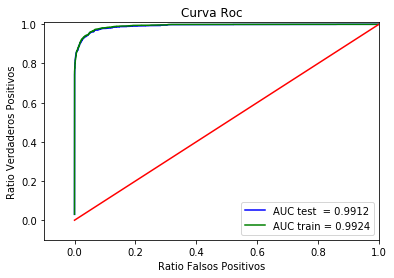

############################
############################
Min samples leaf =  30
       Max depth =  7
n_estimators     =  50
############################
############################

Recall = 0.89596
Precision = 0.97905
Accuracy = 0.96323
Auc = 0.99427
Tiempo ejecución = 0:00:01.259392



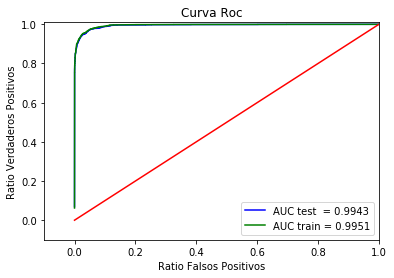

############################
############################
Min samples leaf =  30
       Max depth =  7
n_estimators     =  100
############################
############################

Recall = 0.88780
Precision = 0.97273
Accuracy = 0.95909
Auc = 0.99429
Tiempo ejecución = 0:00:02.482375



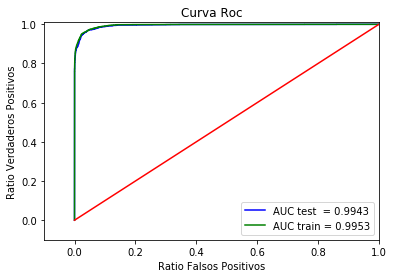

############################
############################
Min samples leaf =  30
       Max depth =  7
n_estimators     =  200
############################
############################

Recall = 0.89106
Precision = 0.97240
Accuracy = 0.95995
Auc = 0.99383
Tiempo ejecución = 0:00:04.917130



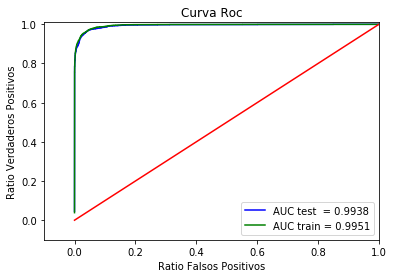

############################
############################
Min samples leaf =  30
       Max depth =  8
n_estimators     =  10
############################
############################

Recall = 0.90249
Precision = 0.96678
Accuracy = 0.96165
Auc = 0.99226
Tiempo ejecución = 0:00:00.301541



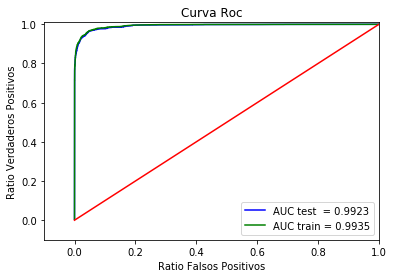

############################
############################
Min samples leaf =  30
       Max depth =  8
n_estimators     =  50
############################
############################

Recall = 0.90575
Precision = 0.97625
Accuracy = 0.96530
Auc = 0.99518
Tiempo ejecución = 0:00:01.433422



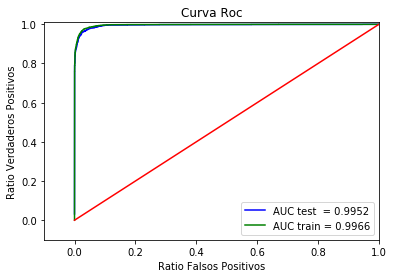

############################
############################
Min samples leaf =  30
       Max depth =  8
n_estimators     =  100
############################
############################

Recall = 0.90698
Precision = 0.97117
Accuracy = 0.96421
Auc = 0.99515
Tiempo ejecución = 0:00:02.717553



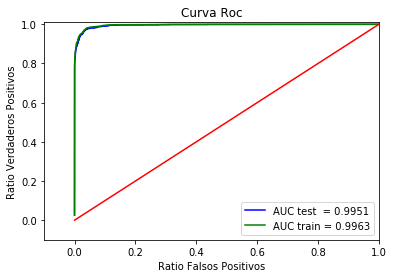

############################
############################
Min samples leaf =  30
       Max depth =  8
n_estimators     =  200
############################
############################

Recall = 0.91228
Precision = 0.97344
Accuracy = 0.96640
Auc = 0.99503
Tiempo ejecución = 0:00:05.465551



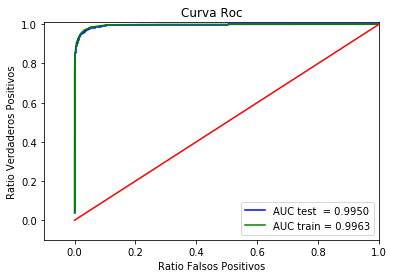

############################
############################
Min samples leaf =  30
       Max depth =  9
n_estimators     =  10
############################
############################

Recall = 0.90004
Precision = 0.97223
Accuracy = 0.96250
Auc = 0.99354
Tiempo ejecución = 0:00:00.299633



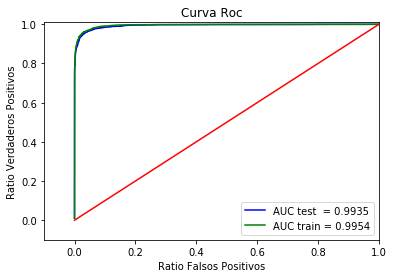

############################
############################
Min samples leaf =  30
       Max depth =  9
n_estimators     =  50
############################
############################

Recall = 0.92574
Precision = 0.97049
Accuracy = 0.96944
Auc = 0.99557
Tiempo ejecución = 0:00:01.417767



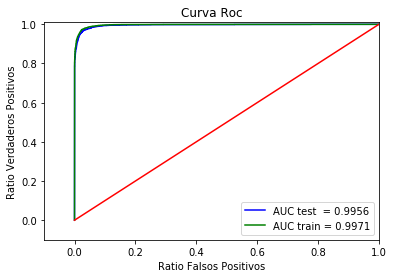

############################
############################
Min samples leaf =  30
       Max depth =  9
n_estimators     =  100
############################
############################

Recall = 0.92003
Precision = 0.97240
Accuracy = 0.96835
Auc = 0.99551
Tiempo ejecución = 0:00:02.740678



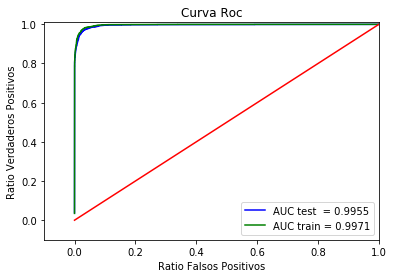

############################
############################
Min samples leaf =  30
       Max depth =  9
n_estimators     =  200
############################
############################

Recall = 0.92534
Precision = 0.97256
Accuracy = 0.96993
Auc = 0.99604
Tiempo ejecución = 0:00:05.814665



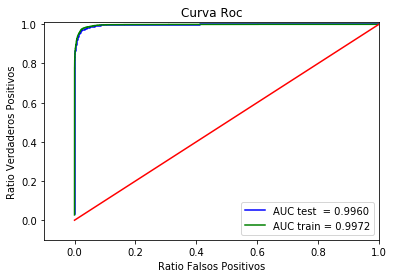

############################
############################
Min samples leaf =  50
       Max depth =  4
n_estimators     =  10
############################
############################

Recall = 0.84741
Precision = 0.96695
Accuracy = 0.94582
Auc = 0.98490
Tiempo ejecución = 0:00:00.205198



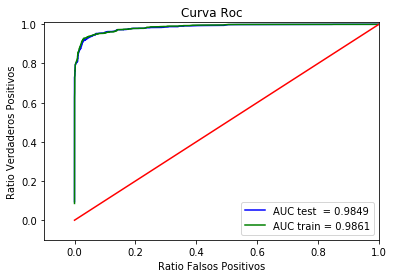

############################
############################
Min samples leaf =  50
       Max depth =  4
n_estimators     =  50
############################
############################

Recall = 0.85639
Precision = 0.95976
Accuracy = 0.94643
Auc = 0.98591
Tiempo ejecución = 0:00:01.043328



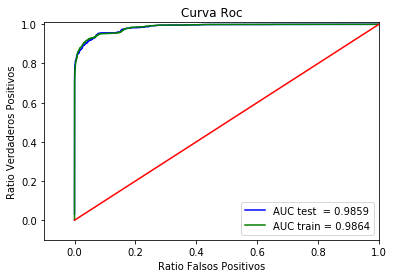

############################
############################
Min samples leaf =  50
       Max depth =  4
n_estimators     =  100
############################
############################

Recall = 0.83313
Precision = 0.97424
Accuracy = 0.94363
Auc = 0.98362
Tiempo ejecución = 0:00:02.121784



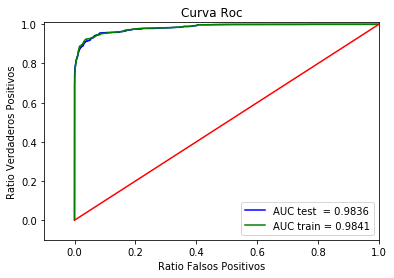

############################
############################
Min samples leaf =  50
       Max depth =  4
n_estimators     =  200
############################
############################

Recall = 0.83884
Precision = 0.97073
Accuracy = 0.94436
Auc = 0.98359
Tiempo ejecución = 0:00:03.979909



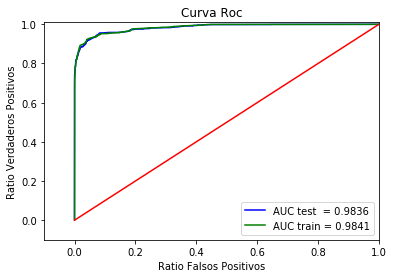

############################
############################
Min samples leaf =  50
       Max depth =  5
n_estimators     =  10
############################
############################

Recall = 0.84496
Precision = 0.96415
Accuracy = 0.94436
Auc = 0.98185
Tiempo ejecución = 0:00:00.370332



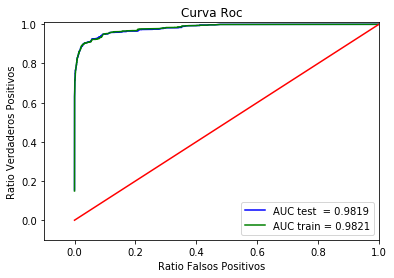

############################
############################
Min samples leaf =  50
       Max depth =  5
n_estimators     =  50
############################
############################

Recall = 0.87393
Precision = 0.96183
Accuracy = 0.95203
Auc = 0.98963
Tiempo ejecución = 0:00:01.408298



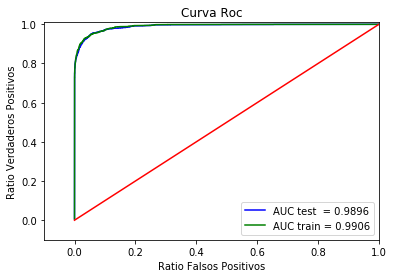

############################
############################
Min samples leaf =  50
       Max depth =  5
n_estimators     =  100
############################
############################

Recall = 0.86659
Precision = 0.96721
Accuracy = 0.95142
Auc = 0.98963
Tiempo ejecución = 0:00:02.581335



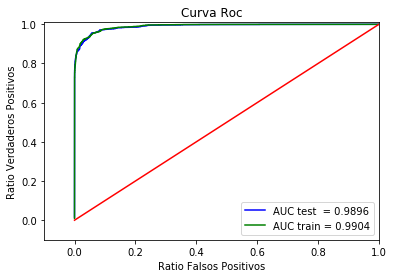

############################
############################
Min samples leaf =  50
       Max depth =  5
n_estimators     =  200
############################
############################

Recall = 0.87148
Precision = 0.96608
Accuracy = 0.95252
Auc = 0.98874
Tiempo ejecución = 0:00:06.375180



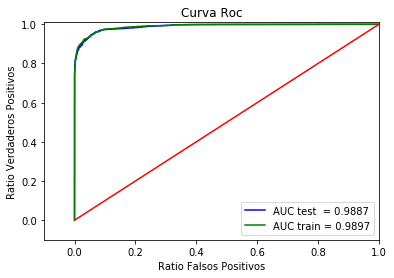

############################
############################
Min samples leaf =  50
       Max depth =  6
n_estimators     =  10
############################
############################

Recall = 0.87515
Precision = 0.95716
Accuracy = 0.95106
Auc = 0.99011
Tiempo ejecución = 0:00:00.369075



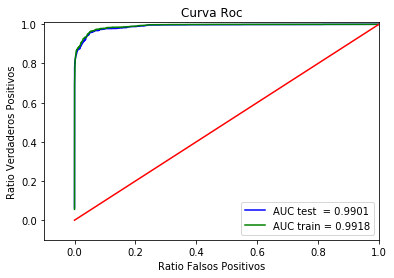

############################
############################
Min samples leaf =  50
       Max depth =  6
n_estimators     =  50
############################
############################

Recall = 0.88576
Precision = 0.96963
Accuracy = 0.95763
Auc = 0.99258
Tiempo ejecución = 0:00:01.274140



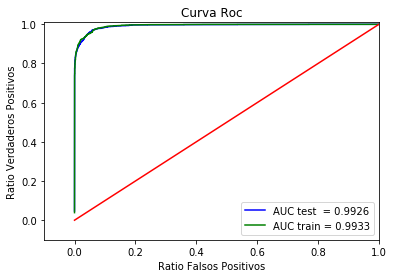

############################
############################
Min samples leaf =  50
       Max depth =  6
n_estimators     =  100
############################
############################

Recall = 0.88576
Precision = 0.96489
Accuracy = 0.95629
Auc = 0.99182
Tiempo ejecución = 0:00:02.731223



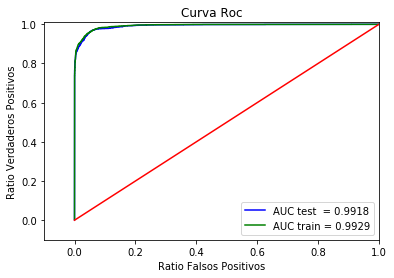

############################
############################
Min samples leaf =  50
       Max depth =  6
n_estimators     =  200
############################
############################

Recall = 0.87515
Precision = 0.96752
Accuracy = 0.95398
Auc = 0.99125
Tiempo ejecución = 0:00:05.351543



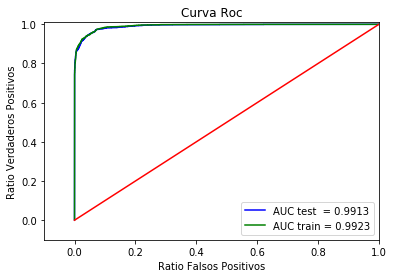

############################
############################
Min samples leaf =  50
       Max depth =  7
n_estimators     =  10
############################
############################

Recall = 0.88168
Precision = 0.96473
Accuracy = 0.95508
Auc = 0.99262
Tiempo ejecución = 0:00:00.280206



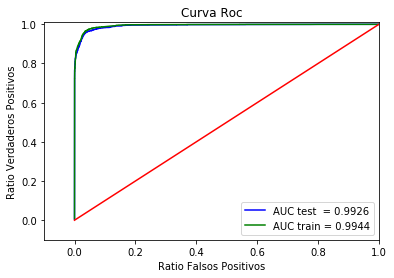

############################
############################
Min samples leaf =  50
       Max depth =  7
n_estimators     =  50
############################
############################

Recall = 0.88943
Precision = 0.96631
Accuracy = 0.95776
Auc = 0.99327
Tiempo ejecución = 0:00:01.353047



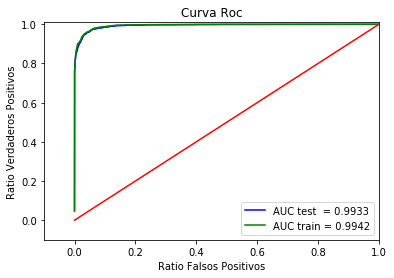

############################
############################
Min samples leaf =  50
       Max depth =  7
n_estimators     =  100
############################
############################

Recall = 0.89351
Precision = 0.96646
Accuracy = 0.95897
Auc = 0.99378
Tiempo ejecución = 0:00:02.552854



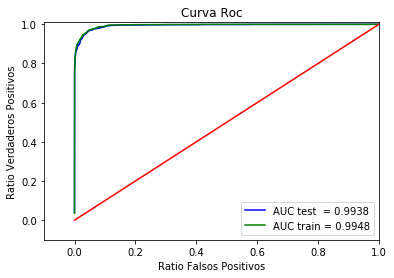

############################
############################
Min samples leaf =  50
       Max depth =  7
n_estimators     =  200
############################
############################

Recall = 0.89066
Precision = 0.96764
Accuracy = 0.95849
Auc = 0.99353
Tiempo ejecución = 0:00:05.173840



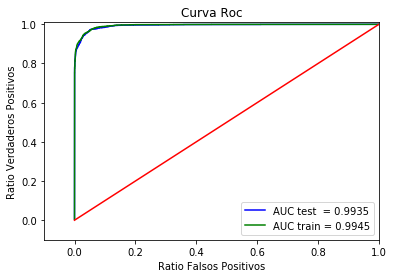

############################
############################
Min samples leaf =  50
       Max depth =  8
n_estimators     =  10
############################
############################

Recall = 0.89678
Precision = 0.97128
Accuracy = 0.96129
Auc = 0.99342
Tiempo ejecución = 0:00:00.342570



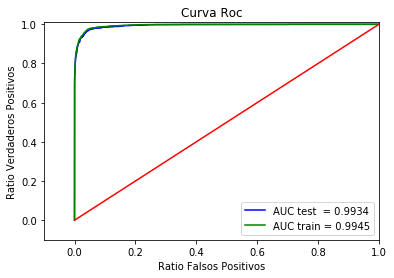

############################
############################
Min samples leaf =  50
       Max depth =  8
n_estimators     =  50
############################
############################

Recall = 0.89514
Precision = 0.96780
Accuracy = 0.95982
Auc = 0.99390
Tiempo ejecución = 0:00:01.526959



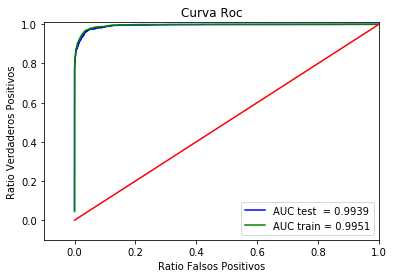

############################
############################
Min samples leaf =  50
       Max depth =  8
n_estimators     =  100
############################
############################

Recall = 0.90126
Precision = 0.96843
Accuracy = 0.96177
Auc = 0.99427
Tiempo ejecución = 0:00:03.009732



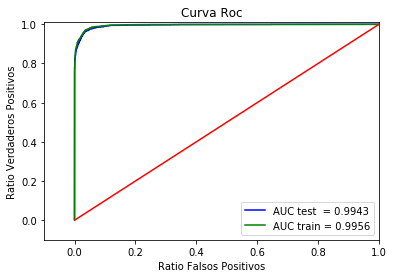

############################
############################
Min samples leaf =  50
       Max depth =  8
n_estimators     =  200
############################
############################

Recall = 0.89841
Precision = 0.96962
Accuracy = 0.96129
Auc = 0.99440
Tiempo ejecución = 0:00:05.662597



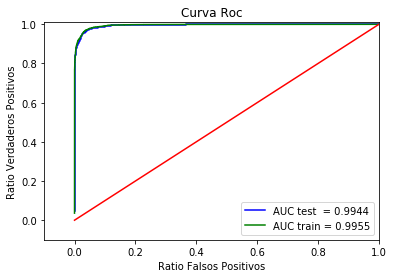

############################
############################
Min samples leaf =  50
       Max depth =  9
n_estimators     =  10
############################
############################

Recall = 0.89841
Precision = 0.95948
Accuracy = 0.95836
Auc = 0.99376
Tiempo ejecución = 0:00:00.320105



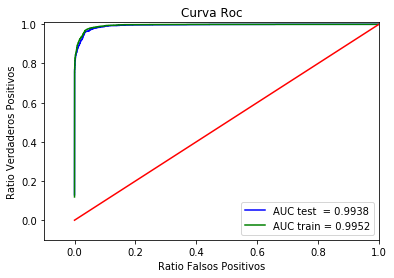

############################
############################
Min samples leaf =  50
       Max depth =  9
n_estimators     =  50
############################
############################

Recall = 0.90902
Precision = 0.97165
Accuracy = 0.96494
Auc = 0.99519
Tiempo ejecución = 0:00:01.398097



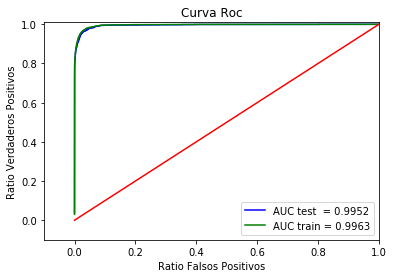

############################
############################
Min samples leaf =  50
       Max depth =  9
n_estimators     =  100
############################
############################

Recall = 0.90534
Precision = 0.96394
Accuracy = 0.96165
Auc = 0.99459
Tiempo ejecución = 0:00:02.683286



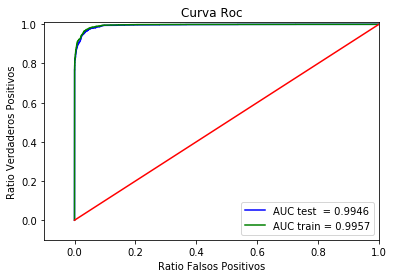

############################
############################
Min samples leaf =  50
       Max depth =  9
n_estimators     =  200
############################
############################

Recall = 0.90738
Precision = 0.96738
Accuracy = 0.96323
Auc = 0.99475
Tiempo ejecución = 0:00:05.515435



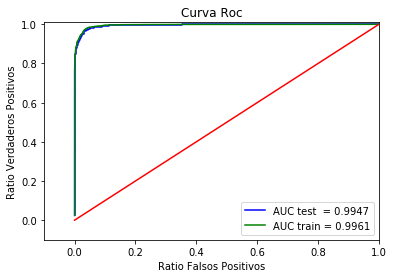

############################
############################
Min samples leaf =  100
       Max depth =  4
n_estimators     =  10
############################
############################

Recall = 0.86373
Precision = 0.94805
Accuracy = 0.94522
Auc = 0.98293
Tiempo ejecución = 0:00:00.215747



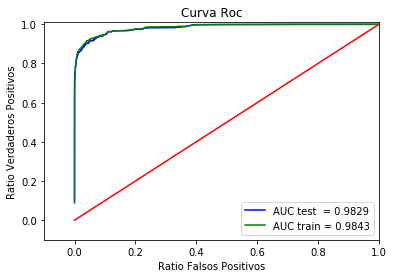

############################
############################
Min samples leaf =  100
       Max depth =  4
n_estimators     =  50
############################
############################

Recall = 0.85720
Precision = 0.97269
Accuracy = 0.95021
Auc = 0.98509
Tiempo ejecución = 0:00:00.865248



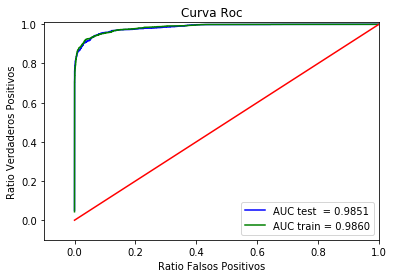

############################
############################
Min samples leaf =  100
       Max depth =  4
n_estimators     =  100
############################
############################

Recall = 0.84823
Precision = 0.96295
Accuracy = 0.94497
Auc = 0.98481
Tiempo ejecución = 0:00:01.856208



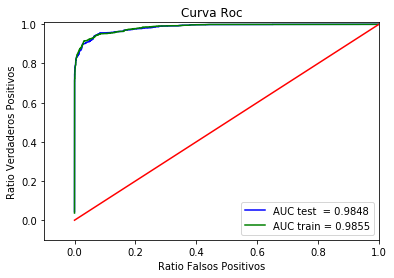

############################
############################
Min samples leaf =  100
       Max depth =  4
n_estimators     =  200
############################
############################

Recall = 0.84986
Precision = 0.97064
Accuracy = 0.94753
Auc = 0.98539
Tiempo ejecución = 0:00:03.637454



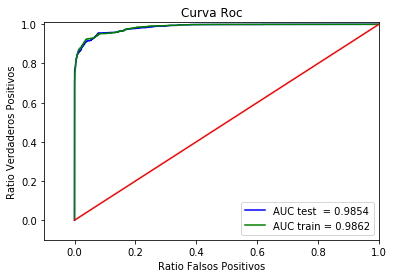

############################
############################
Min samples leaf =  100
       Max depth =  5
n_estimators     =  10
############################
############################

Recall = 0.87107
Precision = 0.95869
Accuracy = 0.95033
Auc = 0.98594
Tiempo ejecución = 0:00:00.232133



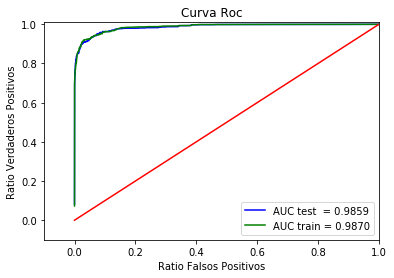

############################
############################
Min samples leaf =  100
       Max depth =  5
n_estimators     =  50
############################
############################

Recall = 0.84945
Precision = 0.97518
Accuracy = 0.94862
Auc = 0.98786
Tiempo ejecución = 0:00:00.996274



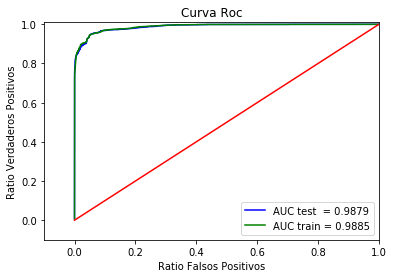

############################
############################
Min samples leaf =  100
       Max depth =  5
n_estimators     =  100
############################
############################

Recall = 0.88127
Precision = 0.95575
Accuracy = 0.95240
Auc = 0.98853
Tiempo ejecución = 0:00:02.014001



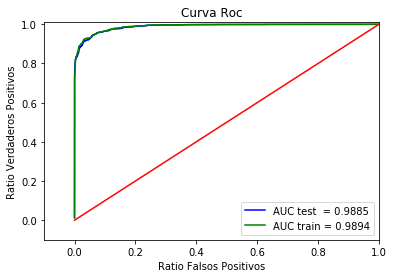

############################
############################
Min samples leaf =  100
       Max depth =  5
n_estimators     =  200
############################
############################

Recall = 0.86577
Precision = 0.96323
Accuracy = 0.95009
Auc = 0.98815
Tiempo ejecución = 0:00:04.179997



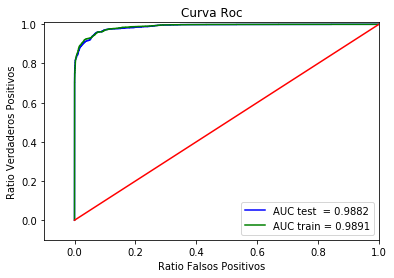

############################
############################
Min samples leaf =  100
       Max depth =  6
n_estimators     =  10
############################
############################

Recall = 0.87923
Precision = 0.95608
Accuracy = 0.95191
Auc = 0.98892
Tiempo ejecución = 0:00:00.249092



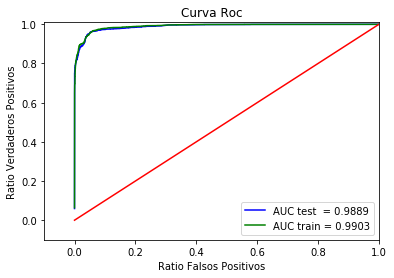

############################
############################
Min samples leaf =  100
       Max depth =  6
n_estimators     =  50
############################
############################

Recall = 0.87801
Precision = 0.96200
Accuracy = 0.95325
Auc = 0.99010
Tiempo ejecución = 0:00:01.131025



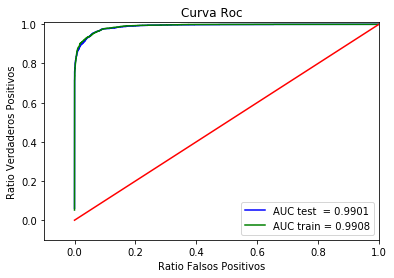

############################
############################
Min samples leaf =  100
       Max depth =  6
n_estimators     =  100
############################
############################

Recall = 0.87475
Precision = 0.96577
Accuracy = 0.95337
Auc = 0.99026
Tiempo ejecución = 0:00:02.244407



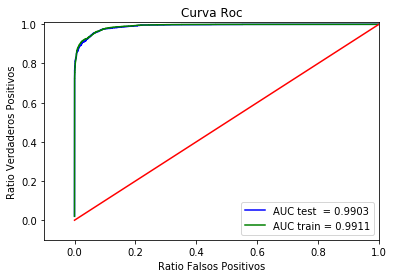

############################
############################
Min samples leaf =  100
       Max depth =  6
n_estimators     =  200
############################
############################

Recall = 0.88086
Precision = 0.96384
Accuracy = 0.95459
Auc = 0.99088
Tiempo ejecución = 0:00:04.400360



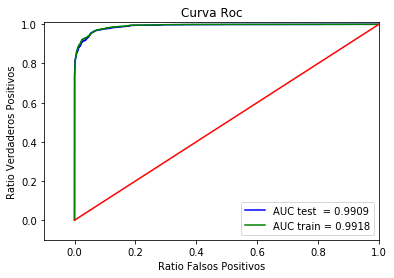

############################
############################
Min samples leaf =  100
       Max depth =  7
n_estimators     =  10
############################
############################

Recall = 0.85149
Precision = 0.97889
Accuracy = 0.95021
Auc = 0.98981
Tiempo ejecución = 0:00:00.271777



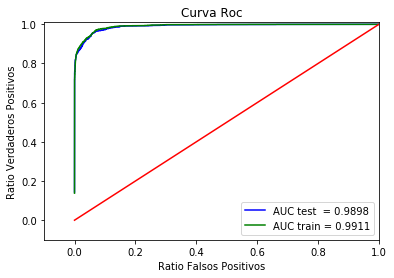

############################
############################
Min samples leaf =  100
       Max depth =  7
n_estimators     =  50
############################
############################

Recall = 0.88617
Precision = 0.96106
Accuracy = 0.95532
Auc = 0.99226
Tiempo ejecución = 0:00:01.339906



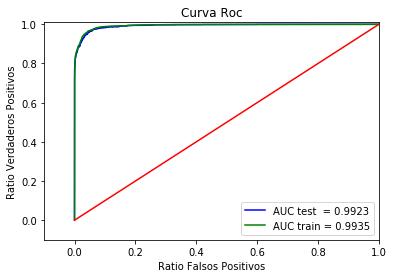

############################
############################
Min samples leaf =  100
       Max depth =  7
n_estimators     =  100
############################
############################

Recall = 0.88862
Precision = 0.96201
Accuracy = 0.95629
Auc = 0.99249
Tiempo ejecución = 0:00:02.696438



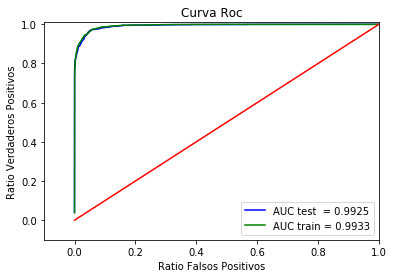

############################
############################
Min samples leaf =  100
       Max depth =  7
n_estimators     =  200
############################
############################

Recall = 0.88862
Precision = 0.96372
Accuracy = 0.95678
Auc = 0.99210
Tiempo ejecución = 0:00:04.786288



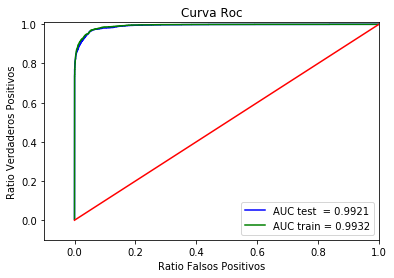

############################
############################
Min samples leaf =  100
       Max depth =  8
n_estimators     =  10
############################
############################

Recall = 0.88739
Precision = 0.95646
Accuracy = 0.95435
Auc = 0.98983
Tiempo ejecución = 0:00:00.289380



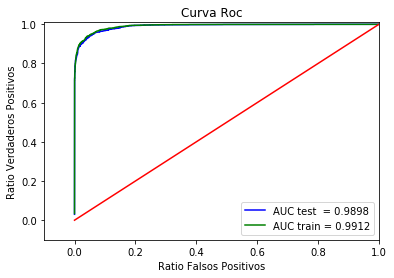

############################
############################
Min samples leaf =  100
       Max depth =  8
n_estimators     =  50
############################
############################

Recall = 0.89147
Precision = 0.96171
Accuracy = 0.95702
Auc = 0.99193
Tiempo ejecución = 0:00:01.387632



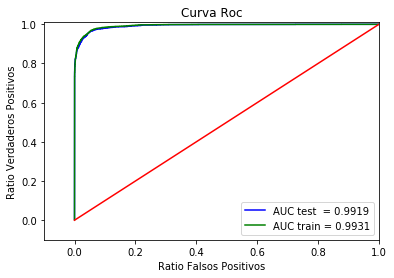

############################
############################
Min samples leaf =  100
       Max depth =  8
n_estimators     =  100
############################
############################

Recall = 0.89555
Precision = 0.96145
Accuracy = 0.95812
Auc = 0.99247
Tiempo ejecución = 0:00:02.547218



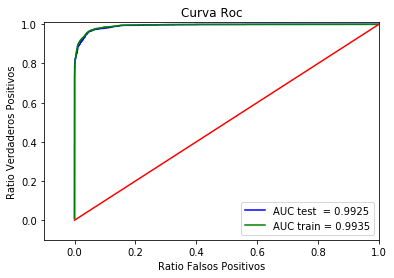

############################
############################
Min samples leaf =  100
       Max depth =  8
n_estimators     =  200
############################
############################

Recall = 0.89963
Precision = 0.95828
Accuracy = 0.95836
Auc = 0.99292
Tiempo ejecución = 0:00:04.953173



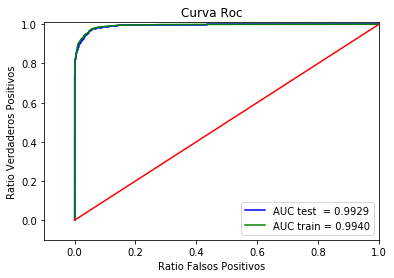

############################
############################
Min samples leaf =  100
       Max depth =  9
n_estimators     =  10
############################
############################

Recall = 0.89066
Precision = 0.95161
Accuracy = 0.95386
Auc = 0.99255
Tiempo ejecución = 0:00:00.295531



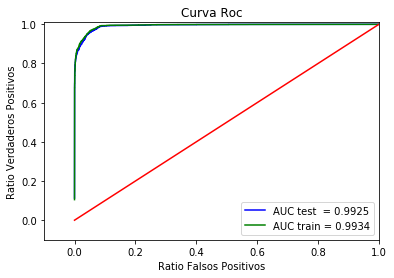

############################
############################
Min samples leaf =  100
       Max depth =  9
n_estimators     =  50
############################
############################

Recall = 0.89229
Precision = 0.96556
Accuracy = 0.95836
Auc = 0.99299
Tiempo ejecución = 0:00:01.282100



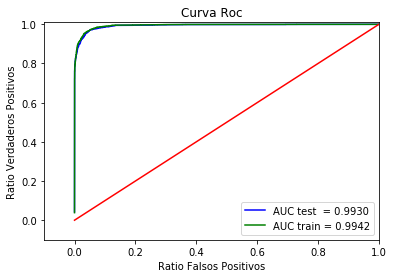

############################
############################
Min samples leaf =  100
       Max depth =  9
n_estimators     =  100
############################
############################

Recall = 0.89882
Precision = 0.95824
Accuracy = 0.95812
Auc = 0.99321
Tiempo ejecución = 0:00:02.611884



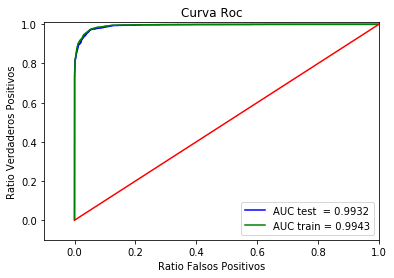

############################
############################
Min samples leaf =  100
       Max depth =  9
n_estimators     =  200
############################
############################

Recall = 0.89922
Precision = 0.95577
Accuracy = 0.95751
Auc = 0.99281
Tiempo ejecución = 0:00:05.205306



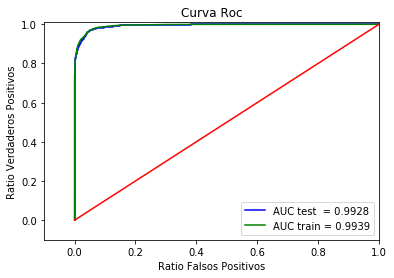

In [49]:
min_samples_leaf = [5,10,20,30,50,100]
max_depth = range(4,10)
n_estimators = [10,50,100,200]

resultados_randfor = random_forest(X_train, X_test, y_train, y_test, max_depth,min_samples_leaf, n_estimators)

In [50]:
resultados_randfor

min_samples_leaf max_depth n_estimators Recall_train Precision_train  \
0                  5         4           10     0.839986         0.97561   
1                  5         4           50      0.85873        0.970196   
2                  5         4          100     0.855953        0.970102   
3                  5         4          200     0.856994        0.976275   
4                  5         5           10     0.887713        0.968934   
5                  5         5           50     0.886498        0.970734   
6                  5         5          100     0.881812        0.972999   
7                  5         5          200     0.887539        0.972613   
8                  5         6           10     0.897258        0.978055   
9                  5         6           50     0.885977        0.981731   
10                 5         6          100     0.897605         0.97714   
11                 5         6          200     0.893613        0.976299   
12                 5         7           10       0.9042         0.97657   
13                 5         7           50     0.911142        0.979478   
14                 5         7          100     0.907324        0.977379   
15                 5         7          200     0.910274        0.977815   
16                 5         8           10     0.903159        0.983185   
17                 5         8           50     0.929365         0.98041   
18                 5         8          100     0.924679         0.98212   
19                 5         8          200     0.922249        0.981892   
20                 5         9           10     0.938042        0.981122   
21                 5         9           50     0.940299         0.97957   
22                 5         9          100     0.940993        0.982602   
23                 5         9          200     0.946546        0.983411   
24                10         4           10     0.836342        0.983469   
25                10         4           50     0.851788        0.974777   
26                10         4          100     0.871746        0.969317   
27                10         4          200     0.864804        0.969833   
28                10         5           10     0.864283        0.980122   
29                10         5           50     0.883027        0.970807   
..               ...       ...          ...          ...             ...   
114               50         8          100     0.915654        0.970924   
115               50         8          200     0.912183        0.973874   
116               50         9           10     0.917043        0.961952   
117               50         9           50     0.922596        0.972736   
118               50         9          100     0.920687        0.966478   
119               50         9          200     0.918778         0.97013   
120              100         4           10      0.87487         0.95257   
121              100         4           50     0.869316        0.971867   
122              100         4          100     0.862721        0.963746   
123              100         4          200     0.862201        0.969177   
124              100         5           10      0.88268        0.957275   
125              100         5           50     0.856994        0.976082   
126              100         5          100     0.890837        0.959978   
127              100         5          200     0.880423        0.962984   
128              100         6           10     0.892919        0.958993   
129              100         6           50      0.88858          0.9606   
130              100         6          100     0.884936        0.968287   
131              100         6          200     0.890663         0.96448   
132              100         7           10     0.855085        0.979523   
133              100         7           50     0.895869        0.961983   
134              100         7          100     0.89

### Mejor modelo de Random forest

In [51]:
resultados_randfor[resultados_randfor['Recall_test'] == max(resultados_randfor['Recall_test'])]

min_samples_leaf max_depth n_estimators Recall_train Precision_train  \
45               10         9           50     0.950364        0.979957   

   Accuracy_train Auc_train Recall_test Precision_test Accuracy_test  \
45       0.979231  0.998151    0.941248       0.976715      0.975773   

    Auc_test Tiempo ejecución  
45  0.996911   0:00:01.460773

Aquí vemos que el mejor random_forest es el que tiene los parámetros:

- *min_samples_leaf = 10*
- *max_depth = 9*
- *n_estimators = 50*

In [54]:
print("El Recall en test obtenido es: ", '%0.5f'%resultados_randfor[resultados_randfor['Recall_test'] == max(resultados_randfor['Recall_test'])]['Recall_test'].values)

El Recall en test obtenido es:  0.94125


In [53]:
randfor = RandomForestClassifier(min_samples_leaf = 10, max_depth = 9, n_estimators=50)
randforfit = randfor.fit(X_train,y_train.values.ravel())
y_pred_test_randfor = randforfit.predict(X_test)

### Reporte de clasificación

In [55]:
print(classification_report(y_test, y_pred_test_randfor))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      5763
          1       0.98      0.93      0.95      2451

avg / total       0.97      0.97      0.97      8214



### Matriz de confusión

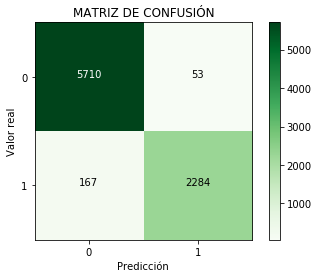

In [56]:
matconf = confusion_matrix(y_test, y_pred_test_randfor)
matriz_confusion(matconf)
plt.show()

### Curva ROC

In [81]:
y_roc_train_randfor = randforfit.predict_proba(X_train)[:,1]
fpr_train_randfor, tpr_train_randfor, thresholds_train_randfor = roc_curve(y_train,y_roc_train_randfor)
roc_auc_train_randfor = auc(fpr_train_randfor,tpr_train_randfor)
                
y_roc_test_randfor = randforfit.predict_proba(X_test)[:,1]
fpr_test_randfor, tpr_test_randfor, thresholds_test_randfor = roc_curve(y_test,y_roc_test_randfor)
roc_auc_test_randfor = auc(fpr_test_randfor,tpr_test_randfor)


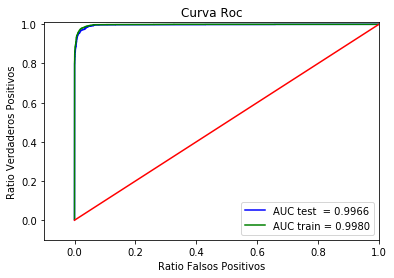

In [82]:
plot_curva_roc(fpr_train_randfor,tpr_train_randfor,roc_auc_train_randfor,fpr_test_randfor,tpr_test_randfor,roc_auc_test_randfor)

## 1.6. Gradient Boosting

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

Definimos la función **gradient_boosting**, en la que los parámetros de entrada son:

- *X_train*
- *X_test*
- *y_train*
- *y_test*
- *min_samples_leaf*: Vector que contiene diferentes valores para *min_samples_leaf*
- *max_depth*: Vector que contiene diferentes valores para *max_depth*
- *n_estimators*: Vector que contiene diferentes valores para *n_estimators*

Como sálida tenemos la tabla de resultados *resultados_gradboost*, que contiene los resultados para cada uno de los modelos resultantes de los parámetros. 

En la función, se crea un bucle para probar diferentes parámetros de **min_samples_leaf**, **max_depth** y **n_estimators**. Sacaremos en una tabla los valores de los estadística *Recall*, *Precision*, *Accuracy* y *Auc*. Además sacaré la curva ROC para cada uno. Y esto a su vez estará sacado tanto para Test como para Train. Todo esto se guarda en la tabla **resultados_gradboost**.

In [63]:
def gradient_boosting(X_train, X_test, y_train, y_test, max_depth ,min_samples_leaf, n_estimators):
    indice = 0
    #DataFrame que tiene la tabla de resultados de los estadísticos
    resultados_gradboost = pd.DataFrame(columns = ['min_samples_leaf','max_depth','n_estimators',\
                                                'Recall_train', 'Precision_train','Accuracy_train','Auc_train',\
                                                'Recall_test', 'Precision_test','Accuracy_test','Auc_test','Tiempo ejecución'])

    for minsamples in min_samples_leaf:
        for maxdepth in max_depth:
            for nestimator in n_estimators:

                resultados_gradboost.loc[indice,'min_samples_leaf'] = minsamples
                resultados_gradboost.loc[indice,'max_depth'] = maxdepth
                resultados_gradboost.loc[indice,'n_estimators'] = nestimator


                ini = datetime.datetime.now()
                print('############################')
                print('############################')
                print('Min samples leaf = ',minsamples)
                print('       Max depth = ',maxdepth)
                print('    n_estimators = ',nestimator)
                print('############################')
                print('############################')
                #Inicializamos vector de de recall, precision, accuracy y auc.
                recall_valores_train = []
                precision_valores_train = []
                accuracy_valores_train = []
                auc_valores_train = []
                recall_valores_test = []
                precision_valores_test = []
                accuracy_valores_test = []
                auc_valores_test = []
                #Random Forest 
                gradboost = GradientBoostingClassifier(min_samples_leaf = minsamples, max_depth = maxdepth, n_estimators=nestimator)
                gradboostfit = gradboost.fit(X_train,y_train.values.ravel())
                y_pred_train = gradboostfit.predict(X_train)
                y_pred_test = gradboostfit.predict(X_test)



                #Recall train
                recall = recall_score(y_train,y_pred_train)
                recall_valores_train.append(recall)
                #Precision train       
                precision = precision_score(y_train, y_pred_train)
                precision_valores_train.append(precision)
                #Accuracy train
                accuracy = accuracy_score(y_train, y_pred_train)
                accuracy_valores_train.append(accuracy)
                #AUC train
                y_roc_train = gradboostfit.predict_proba(X_train)[:,1]
                fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_roc_train)
                roc_auc_train = auc(fpr_train,tpr_train)
                auc_valores_train.append(roc_auc_train)  


                #Recall
                recall_test = recall_score(y_test,y_pred_test)
                recall_valores_test.append(recall_test)
                #Precision        
                precision_test = precision_score(y_test, y_pred_test)
                precision_valores_test.append(precision_test)
                #Accuracy
                accuracy_test = accuracy_score(y_test, y_pred_test)
                accuracy_valores_test.append(accuracy_test)
                #AUC
                y_roc_test = gradboostfit.predict_proba(X_test)[:,1]
                fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_roc_test)
                roc_auc_test = auc(fpr_test,tpr_test)
                auc_valores_test.append(roc_auc_test)



                # Guardamos los estadísticos en la tabla de resultados
                resultados_gradboost.loc[indice,'Recall_train'] = np.mean(recall_valores_train)
                resultados_gradboost.loc[indice, 'Precision_train'] = np.mean(precision_valores_train)
                resultados_gradboost.loc[indice, 'Accuracy_train'] = np.mean(accuracy_valores_train)
                resultados_gradboost.loc[indice, 'Auc_train'] = np.mean(auc_valores_train)
                resultados_gradboost.loc[indice,'Recall_test'] = np.mean(recall_valores_test)
                resultados_gradboost.loc[indice, 'Precision_test'] = np.mean(precision_valores_test)
                resultados_gradboost.loc[indice, 'Accuracy_test'] = np.mean(accuracy_valores_test)
                resultados_gradboost.loc[indice, 'Auc_test'] = np.mean(auc_valores_test)
                fin = datetime.datetime.now()
                resultados_gradboost.loc[indice, 'Tiempo ejecución'] = fin-ini

                indice += 1
                #Imprimos Recall, Precision, Accuracy y Auc.
                print('')
                print('Recall = ' + str('%0.5f'%np.mean(recall_valores_test)))
                print('Precision = '+str('%0.5f'%np.mean(precision_valores_test)))
                print('Accuracy = '+str('%0.5f'%np.mean(accuracy_valores_test)))
                print('Auc = '+str('%0.5f'%np.mean(auc_valores_test)))
                print('Tiempo ejecución = '+str(fin-ini))
                print('')

                #Curva Roc
                plot_curva_roc(fpr_train,tpr_train,roc_auc_train,fpr_test,tpr_test,roc_auc_test)
            
    return resultados_gradboost
    
    

############################
############################
Min samples leaf =  10
       Max depth =  4
    n_estimators =  10
############################
############################

Recall = 0.89025
Precision = 0.95492
Accuracy = 0.95471
Auc = 0.99242
Tiempo ejecución = 0:00:00.270309



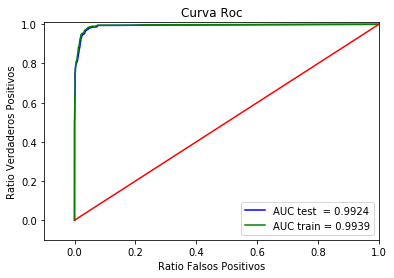

############################
############################
Min samples leaf =  10
       Max depth =  4
    n_estimators =  50
############################
############################

Recall = 0.97348
Precision = 0.97110
Accuracy = 0.98344
Auc = 0.99693
Tiempo ejecución = 0:00:01.115529



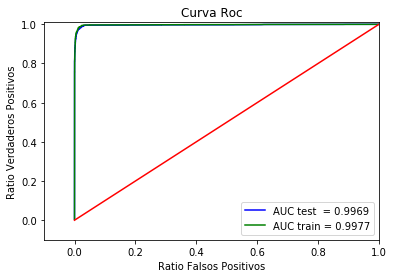

############################
############################
Min samples leaf =  10
       Max depth =  4
    n_estimators =  100
############################
############################

Recall = 0.98409
Precision = 0.97731
Accuracy = 0.98843
Auc = 0.99788
Tiempo ejecución = 0:00:02.047731



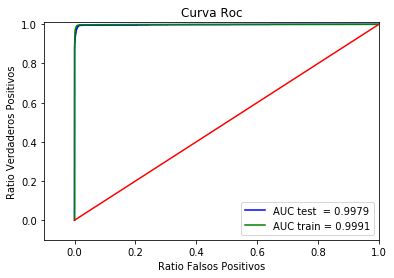

############################
############################
Min samples leaf =  10
       Max depth =  5
    n_estimators =  10
############################
############################

Recall = 0.91636
Precision = 0.97356
Accuracy = 0.96762
Auc = 0.99441
Tiempo ejecución = 0:00:00.313962



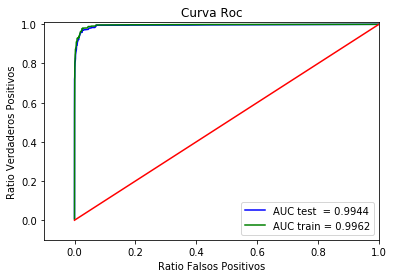

############################
############################
Min samples leaf =  10
       Max depth =  5
    n_estimators =  50
############################
############################

Recall = 0.97960
Precision = 0.97404
Accuracy = 0.98612
Auc = 0.99781
Tiempo ejecución = 0:00:01.458606



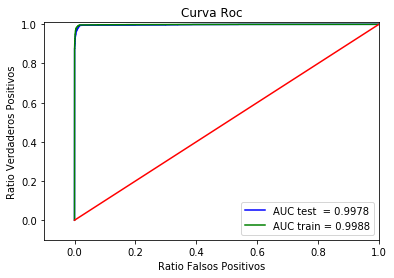

############################
############################
Min samples leaf =  10
       Max depth =  5
    n_estimators =  100
############################
############################

Recall = 0.99102
Precision = 0.98023
Accuracy = 0.99136
Auc = 0.99844
Tiempo ejecución = 0:00:02.635528



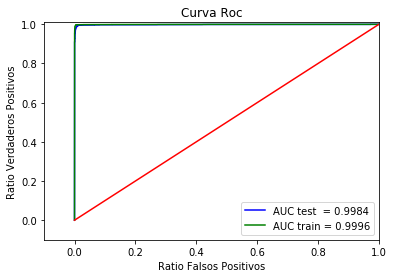

############################
############################
Min samples leaf =  10
       Max depth =  6
    n_estimators =  10
############################
############################

Recall = 0.94166
Precision = 0.97672
Accuracy = 0.97589
Auc = 0.99630
Tiempo ejecución = 0:00:00.388800



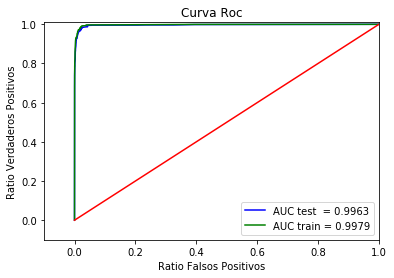

############################
############################
Min samples leaf =  10
       Max depth =  6
    n_estimators =  50
############################
############################

Recall = 0.98817
Precision = 0.97859
Accuracy = 0.99002
Auc = 0.99847
Tiempo ejecución = 0:00:01.804597



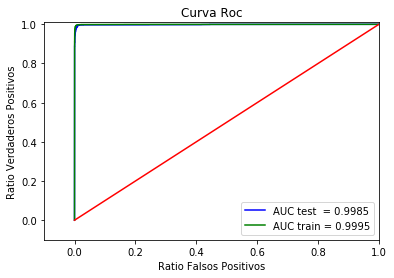

############################
############################
Min samples leaf =  10
       Max depth =  6
    n_estimators =  100
############################
############################

Recall = 0.99347
Precision = 0.98384
Accuracy = 0.99318
Auc = 0.99876
Tiempo ejecución = 0:00:03.417604



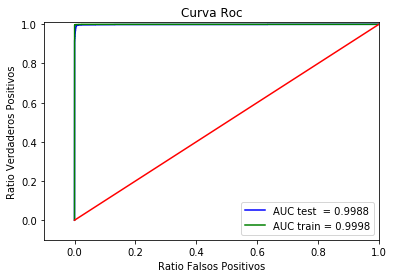

############################
############################
Min samples leaf =  10
       Max depth =  7
    n_estimators =  10
############################
############################

Recall = 0.96369
Precision = 0.97162
Accuracy = 0.98076
Auc = 0.99614
Tiempo ejecución = 0:00:00.446601



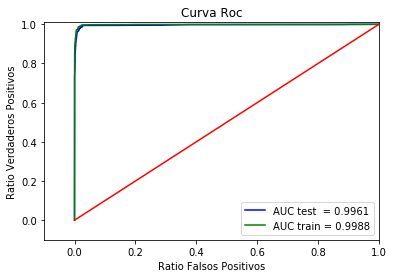

############################
############################
Min samples leaf =  10
       Max depth =  7
    n_estimators =  50
############################
############################

Recall = 0.99062
Precision = 0.98379
Accuracy = 0.99233
Auc = 0.99864
Tiempo ejecución = 0:00:02.539323



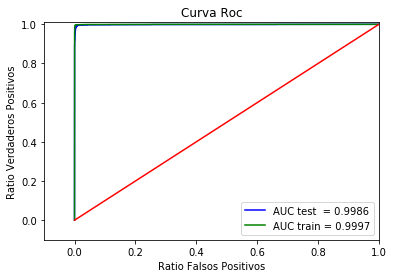

############################
############################
Min samples leaf =  10
       Max depth =  7
    n_estimators =  100
############################
############################

Recall = 0.99266
Precision = 0.98542
Accuracy = 0.99343
Auc = 0.99875
Tiempo ejecución = 0:00:04.291983



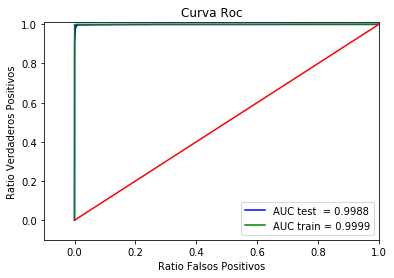

############################
############################
Min samples leaf =  20
       Max depth =  4
    n_estimators =  10
############################
############################

Recall = 0.88943
Precision = 0.95488
Accuracy = 0.95447
Auc = 0.99237
Tiempo ejecución = 0:00:00.269813



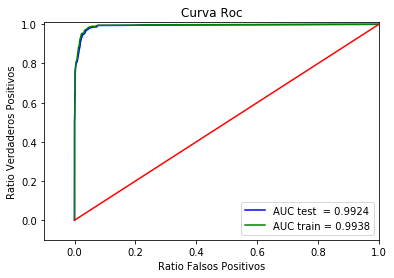

############################
############################
Min samples leaf =  20
       Max depth =  4
    n_estimators =  50
############################
############################

Recall = 0.97062
Precision = 0.96904
Accuracy = 0.98198
Auc = 0.99659
Tiempo ejecución = 0:00:01.246247



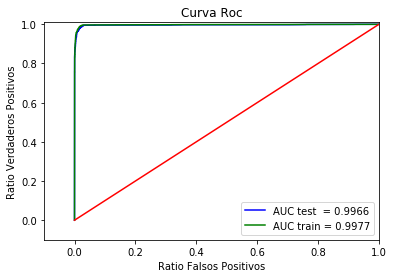

############################
############################
Min samples leaf =  20
       Max depth =  4
    n_estimators =  100
############################
############################

Recall = 0.98776
Precision = 0.97660
Accuracy = 0.98929
Auc = 0.99725
Tiempo ejecución = 0:00:01.980093



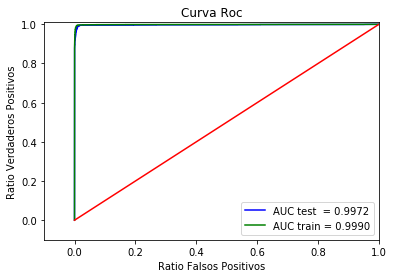

############################
############################
Min samples leaf =  20
       Max depth =  5
    n_estimators =  10
############################
############################

Recall = 0.91554
Precision = 0.97438
Accuracy = 0.96762
Auc = 0.99443
Tiempo ejecución = 0:00:00.298266



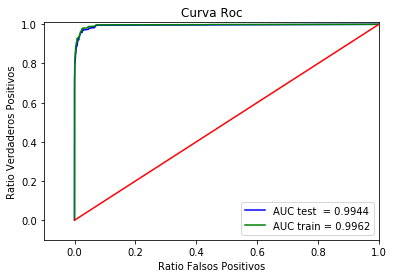

############################
############################
Min samples leaf =  20
       Max depth =  5
    n_estimators =  50
############################
############################

Recall = 0.97960
Precision = 0.97602
Accuracy = 0.98673
Auc = 0.99766
Tiempo ejecución = 0:00:01.355042



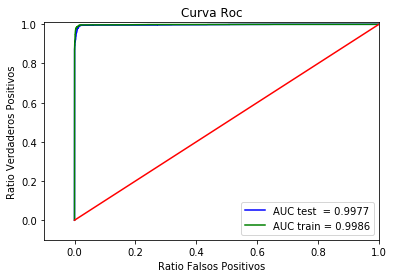

############################
############################
Min samples leaf =  20
       Max depth =  5
    n_estimators =  100
############################
############################

Recall = 0.99062
Precision = 0.97943
Accuracy = 0.99099
Auc = 0.99835
Tiempo ejecución = 0:00:02.632702



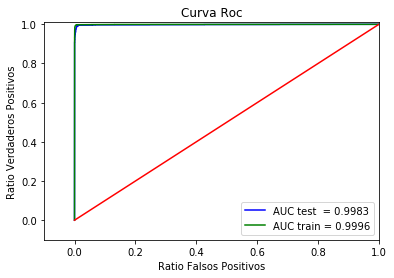

############################
############################
Min samples leaf =  20
       Max depth =  6
    n_estimators =  10
############################
############################

Recall = 0.94247
Precision = 0.97757
Accuracy = 0.97638
Auc = 0.99615
Tiempo ejecución = 0:00:00.377216



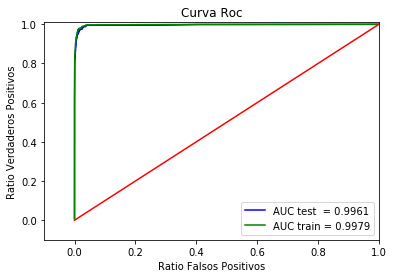

############################
############################
Min samples leaf =  20
       Max depth =  6
    n_estimators =  50
############################
############################

Recall = 0.98735
Precision = 0.97936
Accuracy = 0.99002
Auc = 0.99843
Tiempo ejecución = 0:00:01.739331



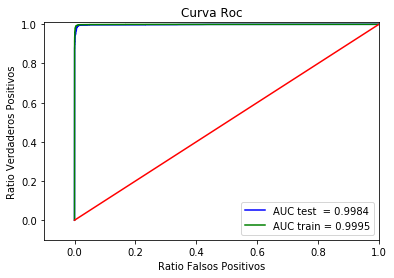

############################
############################
Min samples leaf =  20
       Max depth =  6
    n_estimators =  100
############################
############################

Recall = 0.99266
Precision = 0.98224
Accuracy = 0.99245
Auc = 0.99863
Tiempo ejecución = 0:00:03.505739



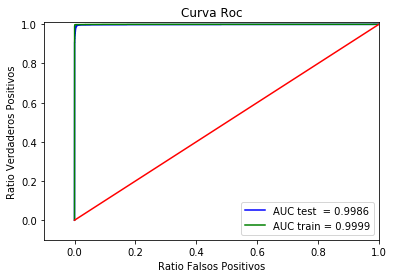

############################
############################
Min samples leaf =  20
       Max depth =  7
    n_estimators =  10
############################
############################

Recall = 0.96002
Precision = 0.97797
Accuracy = 0.98162
Auc = 0.99687
Tiempo ejecución = 0:00:00.445057



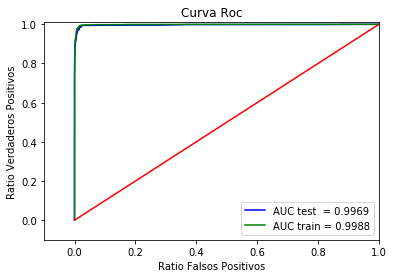

############################
############################
Min samples leaf =  20
       Max depth =  7
    n_estimators =  50
############################
############################

Recall = 0.98980
Precision = 0.98418
Accuracy = 0.99221
Auc = 0.99869
Tiempo ejecución = 0:00:02.036289



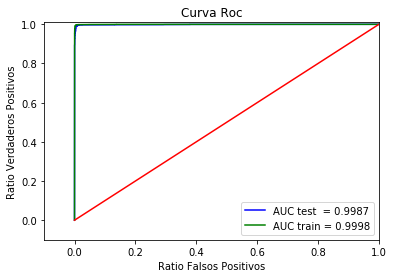

############################
############################
Min samples leaf =  20
       Max depth =  7
    n_estimators =  100
############################
############################

Recall = 0.99306
Precision = 0.98662
Accuracy = 0.99391
Auc = 0.99851
Tiempo ejecución = 0:00:04.015629



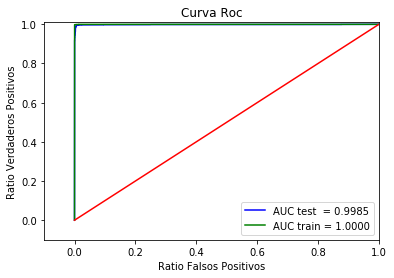

############################
############################
Min samples leaf =  50
       Max depth =  4
    n_estimators =  10
############################
############################

Recall = 0.88943
Precision = 0.95072
Accuracy = 0.95325
Auc = 0.99208
Tiempo ejecución = 0:00:00.256373



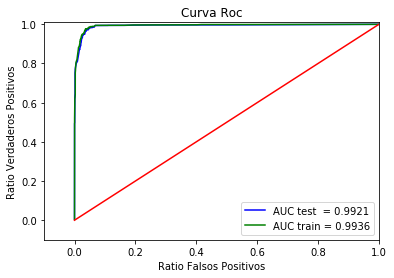

############################
############################
Min samples leaf =  50
       Max depth =  4
    n_estimators =  50
############################
############################

Recall = 0.97266
Precision = 0.96871
Accuracy = 0.98247
Auc = 0.99668
Tiempo ejecución = 0:00:01.522995



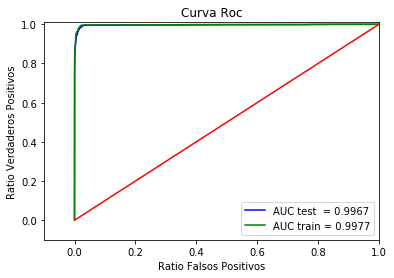

############################
############################
Min samples leaf =  50
       Max depth =  4
    n_estimators =  100
############################
############################

Recall = 0.98817
Precision = 0.97543
Accuracy = 0.98904
Auc = 0.99765
Tiempo ejecución = 0:00:02.184949



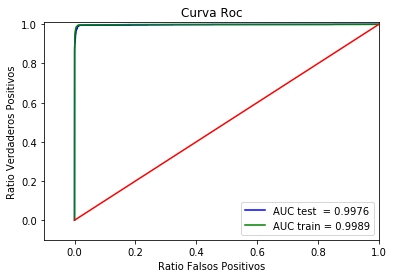

############################
############################
Min samples leaf =  50
       Max depth =  5
    n_estimators =  10
############################
############################

Recall = 0.91840
Precision = 0.96984
Accuracy = 0.96713
Auc = 0.99489
Tiempo ejecución = 0:00:00.298346



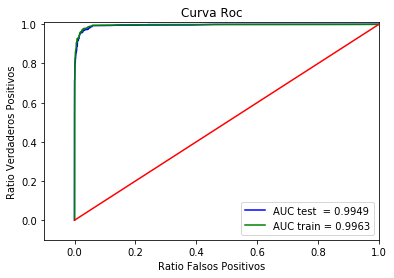

############################
############################
Min samples leaf =  50
       Max depth =  5
    n_estimators =  50
############################
############################

Recall = 0.97552
Precision = 0.97353
Accuracy = 0.98478
Auc = 0.99761
Tiempo ejecución = 0:00:01.312103



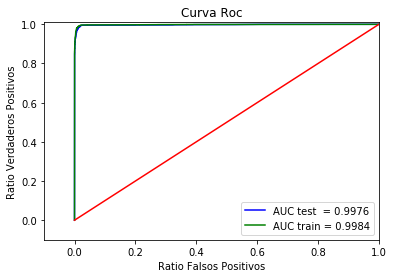

############################
############################
Min samples leaf =  50
       Max depth =  5
    n_estimators =  100
############################
############################

Recall = 0.99021
Precision = 0.97784
Accuracy = 0.99038
Auc = 0.99842
Tiempo ejecución = 0:00:02.473305



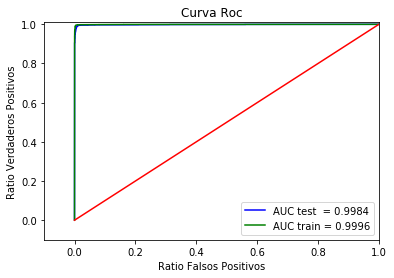

############################
############################
Min samples leaf =  50
       Max depth =  6
    n_estimators =  10
############################
############################

Recall = 0.93431
Precision = 0.97821
Accuracy = 0.97419
Auc = 0.99563
Tiempo ejecución = 0:00:00.373139



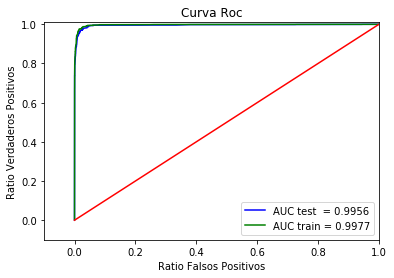

############################
############################
Min samples leaf =  50
       Max depth =  6
    n_estimators =  50
############################
############################

Recall = 0.98450
Precision = 0.97692
Accuracy = 0.98843
Auc = 0.99843
Tiempo ejecución = 0:00:01.611776



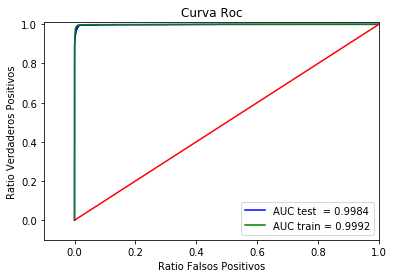

############################
############################
Min samples leaf =  50
       Max depth =  6
    n_estimators =  100
############################
############################

Recall = 0.99266
Precision = 0.98065
Accuracy = 0.99196
Auc = 0.99858
Tiempo ejecución = 0:00:03.172191



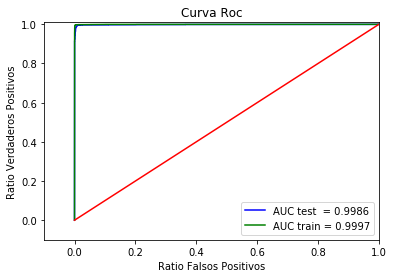

############################
############################
Min samples leaf =  50
       Max depth =  7
    n_estimators =  10
############################
############################

Recall = 0.95594
Precision = 0.97099
Accuracy = 0.97833
Auc = 0.99683
Tiempo ejecución = 0:00:00.435410



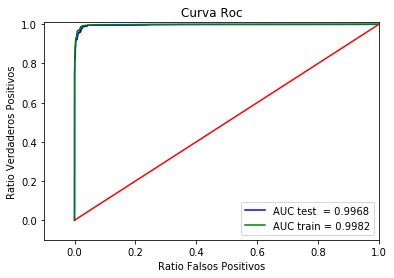

############################
############################
Min samples leaf =  50
       Max depth =  7
    n_estimators =  50
############################
############################

Recall = 0.98898
Precision = 0.97939
Accuracy = 0.99050
Auc = 0.99833
Tiempo ejecución = 0:00:02.206724



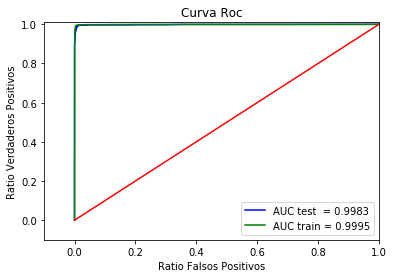

############################
############################
Min samples leaf =  50
       Max depth =  7
    n_estimators =  100
############################
############################

Recall = 0.99266
Precision = 0.98502
Accuracy = 0.99330
Auc = 0.99841
Tiempo ejecución = 0:00:03.754843



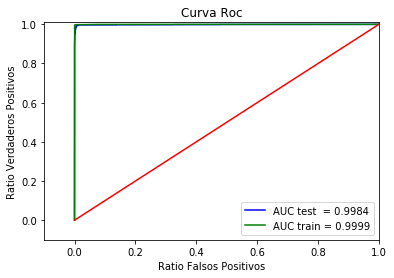

############################
############################
Min samples leaf =  100
       Max depth =  4
    n_estimators =  10
############################
############################

Recall = 0.88331
Precision = 0.94915
Accuracy = 0.95106
Auc = 0.99137
Tiempo ejecución = 0:00:00.275442



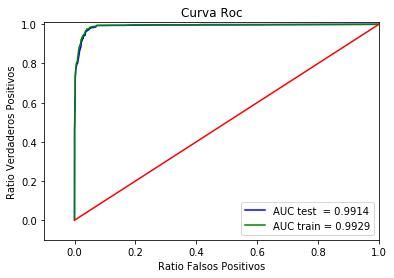

############################
############################
Min samples leaf =  100
       Max depth =  4
    n_estimators =  50
############################
############################

Recall = 0.97062
Precision = 0.96238
Accuracy = 0.97991
Auc = 0.99651
Tiempo ejecución = 0:00:01.111708



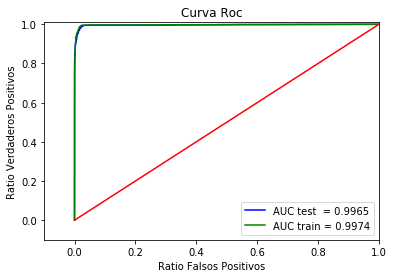

############################
############################
Min samples leaf =  100
       Max depth =  4
    n_estimators =  100
############################
############################

Recall = 0.98654
Precision = 0.97382
Accuracy = 0.98807
Auc = 0.99791
Tiempo ejecución = 0:00:02.061202



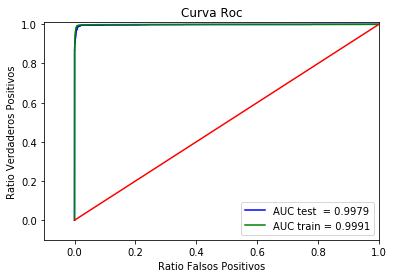

############################
############################
Min samples leaf =  100
       Max depth =  5
    n_estimators =  10
############################
############################

Recall = 0.91677
Precision = 0.96355
Accuracy = 0.96482
Auc = 0.99410
Tiempo ejecución = 0:00:00.297432



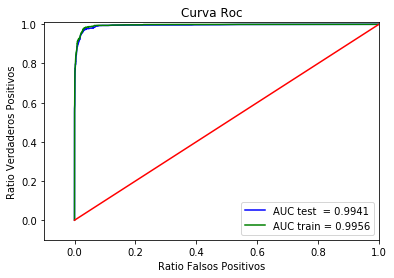

############################
############################
Min samples leaf =  100
       Max depth =  5
    n_estimators =  50
############################
############################

Recall = 0.97674
Precision = 0.97159
Accuracy = 0.98454
Auc = 0.99735
Tiempo ejecución = 0:00:01.775338



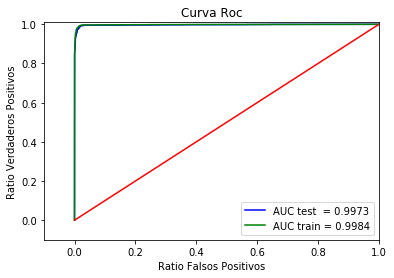

############################
############################
Min samples leaf =  100
       Max depth =  5
    n_estimators =  100
############################
############################

Recall = 0.98898
Precision = 0.97703
Accuracy = 0.98977
Auc = 0.99838
Tiempo ejecución = 0:00:02.722470



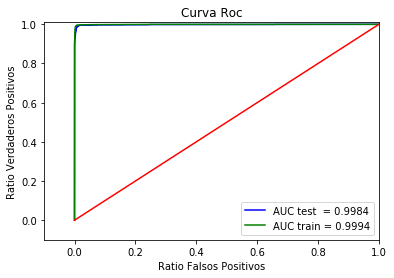

############################
############################
Min samples leaf =  100
       Max depth =  6
    n_estimators =  10
############################
############################

Recall = 0.93635
Precision = 0.96672
Accuracy = 0.97139
Auc = 0.99511
Tiempo ejecución = 0:00:00.417006



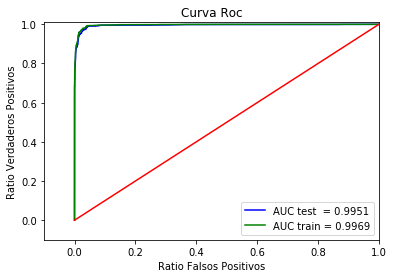

############################
############################
Min samples leaf =  100
       Max depth =  6
    n_estimators =  50
############################
############################

Recall = 0.98490
Precision = 0.97496
Accuracy = 0.98795
Auc = 0.99790
Tiempo ejecución = 0:00:01.700502



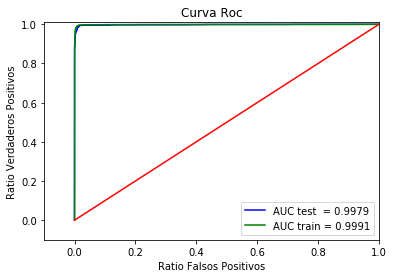

############################
############################
Min samples leaf =  100
       Max depth =  6
    n_estimators =  100
############################
############################

Recall = 0.99143
Precision = 0.97905
Accuracy = 0.99111
Auc = 0.99872
Tiempo ejecución = 0:00:03.167666



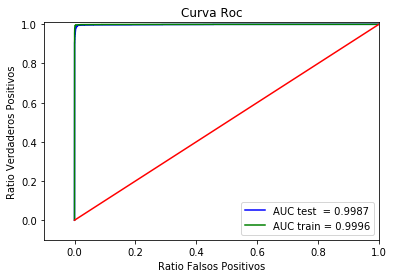

############################
############################
Min samples leaf =  100
       Max depth =  7
    n_estimators =  10
############################
############################

Recall = 0.95390
Precision = 0.96772
Accuracy = 0.97675
Auc = 0.99617
Tiempo ejecución = 0:00:00.397282



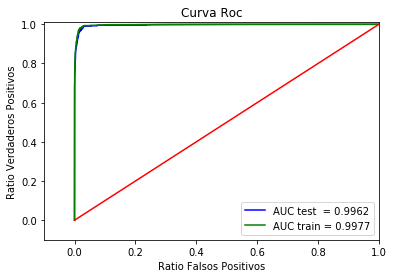

############################
############################
Min samples leaf =  100
       Max depth =  7
    n_estimators =  50
############################
############################

Recall = 0.98776
Precision = 0.97700
Accuracy = 0.98941
Auc = 0.99848
Tiempo ejecución = 0:00:01.971520



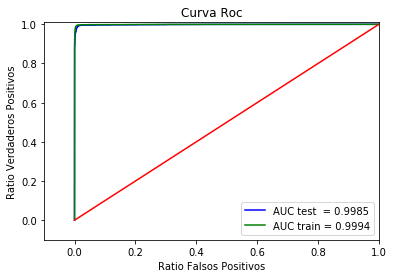

############################
############################
Min samples leaf =  100
       Max depth =  7
    n_estimators =  100
############################
############################

Recall = 0.99143
Precision = 0.98182
Accuracy = 0.99196
Auc = 0.99870
Tiempo ejecución = 0:00:03.596719



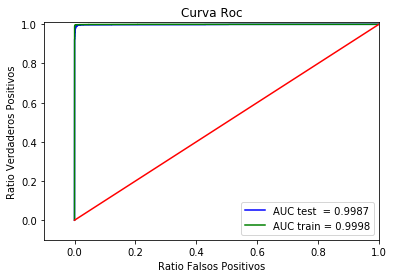

In [65]:
min_samples_leaf = [10,20,50,100]
max_depth = range(4,8)
n_estimators = [10,50,100]
resultados_gradboost = gradient_boosting(X_train, X_test, y_train, y_test,max_depth, min_samples_leaf, n_estimators)

In [66]:
resultados_gradboost

min_samples_leaf max_depth n_estimators Recall_train Precision_train  \
0                10         4           10     0.901597        0.959549   
1                10         4           50     0.981777        0.971993   
2                10         4          100     0.992017        0.980951   
3                10         5           10     0.929191        0.976651   
4                10         5           50     0.987331        0.981031   
5                10         5          100      0.99705        0.987792   
6                10         6           10     0.948629        0.980097   
7                10         6           50     0.994446         0.98691   
8                10         6          100     0.998264        0.995672   
9                10         7           10     0.973967        0.978212   
10               10         7           50     0.996703        0.993083   
11               10         7          100     0.998612        0.998092   
12               20         4           10     0.901076        0.959704   
13               20         4           50     0.977438        0.971872   
14               20         4          100     0.994793        0.980332   
15               20         5           10      0.92815        0.978054   
16               20         5           50     0.987157        0.979339   
17               20         5          100     0.995835        0.987438   
18               20         6           10     0.949323        0.981694   
19               20         6           50     0.992884        0.986379   
20               20         6          100     0.998091        0.993779   
21               20         7           10     0.969802        0.982938   
22               20         7           50     0.995488        0.991016   
23               20         7          100     0.998612        0.997746   
24               50         4           10     0.900208        0.957718   
25               50         4           50     0.978306         0.96989   
26               50         4          100     0.992711        0.978614   
27               50         5           10     0.927282        0.972515   
28               50         5           50     0.984554        0.976588   
29               50         5          100     0.996182        0.985577   
30               50         6           10     0.942728        0.982812   
31               50         6           50     0.990975        0.981606   
32               50         6          100     0.997223         0.99086   
33               50         7           10     0.964596        0.978349   
34               50         7           50      0.99462        0.986912   
35               50         7          100     0.997917        0.994466   
36              100         4           10     0.895002        0.954117   
37              100         4           50     0.978306        0.967393   
38              100         4          100     0.992884         0.97845   
39              100         5           10     0.925373         0.96437   
40              100         5           50     0.983513        0.975387   
41              100         5          100     0.994967        0.982014   
42              100         6           10     0.947761        0.969466   
43              100         6           50     0.990455        0.978231   
44              100         6          100      0.99705        0.987962   
45              100         7           10     0.964943        0.970332   
46              100         7           50     0.993752        0.982836   
47              100         7          100      0.99757        0.992232   

   Accuracy_train Auc_train Recall_test Precision_test Accuracy_test  \
0        0.958983  0.993862    0.890249       0.954923      0.954711   
1        0.986015  0.997706     0.97348       0.971103      0.983443   
2        0.991807   0.99908    0.984088        0.97731      0.988434   
3        0.972029  0.996157    0.916361

### Mejor modelo de Gradient boosting

In [67]:
resultados_gradboost[resultados_gradboost['Recall_test'] == max(resultados_gradboost['Recall_test'])]

min_samples_leaf max_depth n_estimators Recall_train Precision_train  \
8               10         6          100     0.998264        0.995672   

  Accuracy_train Auc_train Recall_test Precision_test Accuracy_test  Auc_test  \
8       0.998174  0.999848    0.993472       0.983838      0.993182  0.998763   

  Tiempo ejecución  
8   0:00:03.417604

Aquí vemos que el mejor gradient boosting es el que tiene los parámetros:

- *min_samples_leaf = 10*
- *max_depth = 6*
- *n_estimators = 100*

In [70]:
print("El Recall en test obtenido es: ", '%0.5f'%resultados_gradboost[resultados_gradboost['Recall_test'] == max(resultados_gradboost['Recall_test'])]['Recall_test'].values)


El Recall en test obtenido es:  0.99347


In [69]:
gradboost = GradientBoostingClassifier(min_samples_leaf = 10, max_depth = 6, n_estimators=100)
gradboostfit = gradboost.fit(X_train,y_train.values.ravel())
y_pred_test_gradboost = gradboostfit.predict(X_test)

### Reporte de clasificación

In [71]:
print(classification_report(y_test, y_pred_test_gradboost))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00      5763
          1       0.98      0.99      0.99      2451

avg / total       0.99      0.99      0.99      8214



### Matriz de confusión

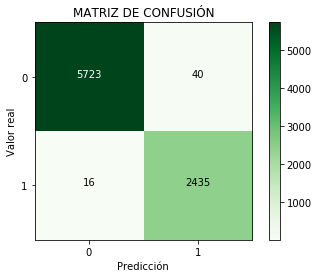

In [72]:
matconf = confusion_matrix(y_test, y_pred_test_gradboost)
matriz_confusion(matconf)
plt.show()

### Curva ROC

In [83]:
y_roc_train_gradboost = gradboostfit.predict_proba(X_train)[:,1]
fpr_train_gradboost, tpr_train_gradboost, thresholds_train_gradboost = roc_curve(y_train,y_roc_train_gradboost)
roc_auc_train_gradboost = auc(fpr_train_gradboost,tpr_train_gradboost)
                
y_roc_test_gradboost = gradboostfit.predict_proba(X_test)[:,1]
fpr_test_gradboost, tpr_test_gradboost, thresholds_test_gradboost = roc_curve(y_test,y_roc_test_gradboost)
roc_auc_test_gradboost = auc(fpr_test_gradboost,tpr_test_gradboost)


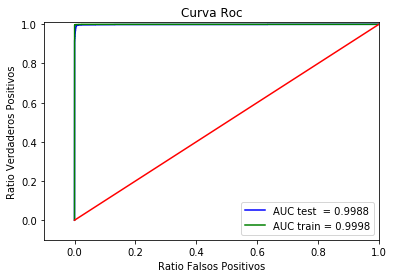

In [84]:
plot_curva_roc(fpr_train_gradboost,tpr_train_gradboost,roc_auc_train_gradboost,fpr_test_gradboost,tpr_test_gradboost,roc_auc_test_gradboost)


### Importancia de variables

In [85]:
gradboostfit.feature_importances_

array([0.08156359, 0.23118714, 0.41164261, 0.09839459, 0.03485427,
       0.1423578 ])

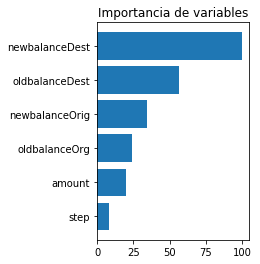

In [181]:
feature_importance = gradboostfit.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns)
plt.title('Importancia de variables')
plt.show()

## 1.7. Conclusiones

Partimos de la base de que hemos obtenido muy buenos resultados de los cuatro modelos. Prueba de ello es que hemos obtenido un **Recall**  superior a 0.90. Además el área bajo la *Curva ROC*, es decir el *Auc* es también alto y superior a 0.9. Por ello hemos obtenido muy buenos resultados.
Y como se muestra en las matrices de confusión obtenidas, los modelos clasifican bastante bien.

De los cuatro modelos realizados *(Regresión logística, Árbol de decisión, Random Forest y Gradient Boosting)* hemos cogido de cada uno los mejores resultados obtenidos a partir de los parámetros. Los juntamos para comparar entre los distintos modelos y veremos cuál es el que mejores resultados hemos obtenido.

#### Regresión Logística

In [163]:
best_reglog = resultados_reglog[(resultados_reglog.c == 0.001) 
                              & (resultados_reglog.penalty == 'l1')]

#### Árbol de decisión

In [164]:
best_ardec = resultados_arbdec[(resultados_arbdec.min_samples_leaf == 5) 
                             & (resultados_arbdec.max_depth == 7)]


#### Random Forest

In [165]:
best_randfor = resultados_randfor[(resultados_randfor.min_samples_leaf == 10) 
                                & (resultados_randfor.max_depth == 9)
                                & (resultados_randfor.n_estimators == 50)]


#### Gradient Boosting

In [166]:
best_gradboost = resultados_gradboost[(resultados_gradboost.min_samples_leaf == 10) 
                                    & (resultados_gradboost.max_depth == 6)
                                    & (resultados_gradboost.n_estimators == 100)]


Guardamos todos los datos en una misma tabla

In [105]:
resultados_modelos = pd.DataFrame(columns = ['Modelo',
                                             'Recall_train', 'Precision_train','Accuracy_train','Auc_train',\
                                             'Recall_test', 'Precision_test','Accuracy_test','Auc_test', \
                                             'Tiempo ejecución'])


In [122]:
resultados_modelos.loc[0,'Modelo'] = 'Regresión Logística'
resultados_modelos.loc[1,'Modelo'] = 'Árbol de decisión'
resultados_modelos.loc[2,'Modelo'] = 'Random Forest'
resultados_modelos.loc[3,'Modelo'] = 'Gradient Boosting'

In [128]:
resultados_modelos.loc[0,['Recall_train', 'Precision_train','Accuracy_train','Auc_train']] = best_reglog[['Recall_train', 'Precision_train','Accuracy_train','Auc_train']].values
resultados_modelos.loc[1,['Recall_train', 'Precision_train','Accuracy_train','Auc_train']] = best_ardec[['Recall_train', 'Precision_train','Accuracy_train','Auc_train']].values
resultados_modelos.loc[2,['Recall_train', 'Precision_train','Accuracy_train','Auc_train']] = best_randfor[['Recall_train', 'Precision_train','Accuracy_train','Auc_train']].values
resultados_modelos.loc[3,['Recall_train', 'Precision_train','Accuracy_train','Auc_train']] = best_gradboost[['Recall_train', 'Precision_train','Accuracy_train','Auc_train']].values

In [129]:
resultados_modelos.loc[0,['Recall_test', 'Precision_test','Accuracy_test','Auc_test']] = best_reglog[['Recall_test', 'Precision_test','Accuracy_test','Auc_test']].values
resultados_modelos.loc[1,['Recall_test', 'Precision_test','Accuracy_test','Auc_test']] = best_ardec[['Recall_test', 'Precision_test','Accuracy_test','Auc_test']].values
resultados_modelos.loc[2,['Recall_test', 'Precision_test','Accuracy_test','Auc_test']] = best_randfor[['Recall_test', 'Precision_test','Accuracy_test','Auc_test']].values
resultados_modelos.loc[3,['Recall_test', 'Precision_test','Accuracy_test','Auc_test']] = best_gradboost[['Recall_test', 'Precision_test','Accuracy_test','Auc_test']].values

In [127]:
resultados_modelos.loc[0,'Tiempo ejecución'] = best_reglog['Tiempo ejecución'].values
resultados_modelos.loc[1,'Tiempo ejecución'] = best_ardec['Tiempo ejecución'].values
resultados_modelos.loc[2,'Tiempo ejecución'] = best_randfor['Tiempo ejecución'].values
resultados_modelos.loc[3,'Tiempo ejecución'] = best_gradboost['Tiempo ejecución'].values

In [130]:
resultados_modelos

Modelo Recall_train Precision_train Accuracy_train Auc_train  \
0  Regresión Logística     0.880597        0.886133       0.930074  0.978003   
1    Árbol de decisión     0.994273          0.9446       0.980744  0.997801   
2        Random Forest     0.950364        0.979957       0.979231  0.998151   
3    Gradient Boosting     0.998264        0.995672       0.998174  0.999848   

  Recall_test Precision_test Accuracy_test  Auc_test  Tiempo ejecución  
0    0.868217       0.892992      0.929632  0.975985  [0:00:01.355849]  
1    0.988576       0.937693      0.976991  0.994791  [0:00:00.110080]  
2    0.941248       0.976715      0.975773  0.996911  [0:00:01.460773]  
3    0.993472       0.983838      0.993182  0.998763  [0:00:03.417604]

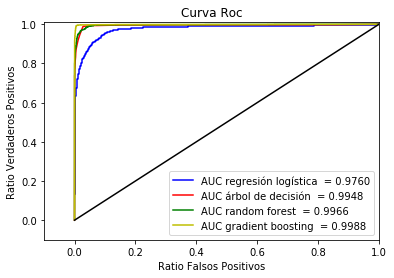

In [176]:
plt.title('Curva Roc')
plt.plot(fpr_test_reglog, tpr_test_reglog, 'b',label='AUC regresión logística  = '+str('%0.4f'%roc_auc_test_reglog))
plt.plot(fpr_test_arbdec, tpr_test_arbdec, 'r',label='AUC árbol de decisión  = '+str('%0.4f'%roc_auc_test_arbdec))
plt.plot(fpr_test_randfor, tpr_test_randfor, 'g',label='AUC random forest  = '+str('%0.4f'%roc_auc_test_randfor))
plt.plot(fpr_test_gradboost, tpr_test_gradboost, 'y',label='AUC gradient boosting  = '+str('%0.4f'%roc_auc_test_gradboost))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k-')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('Ratio Verdaderos Positivos')
plt.xlabel('Ratio Falsos Positivos')
plt.show()

Como se puede observar, en cuanto a los **tiempos de ejecución** son bastante parecidos, siendo el *Gradient Boosting* el que más tiempo tarda, aunque no es algo significativo ya que es muy poco tiempo. 

En cuanto a **Recall** (tanto en test como en train), el modelo que alcanza el valor más alto es *Gradient Boosting*, con un **Recall en test** de 0.993472, teniendo un **Auc en test** 0.998763.

Por tanto el mejor modelo sería el *Gradient Boosting*.

## Gradient boosting: El modelo con mejores resultados

### Test datos no bajomuestreados

Recordemos que hemos realizado una técnica de bajomuestreo. Por ello hay una parte de los datos que no se ha tenido en cuenta en el modelo. Esta parte de los datos son todos casos de NO fraude. Por eso los utilizaremos como otro "test". El modelo debería predecirlos como 0. Vamos a unir la parte del test que teníamos de los datos bajomuestreados y de la parte de los datos que no entro en los bajomuestreados

In [131]:
tb_nobj = df_nobajomuestreo[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']]


In [132]:
X_nobj = tb_nobj.iloc[:, tblmod.columns != 'isFraud']
y_nobj = tb_nobj.iloc[:, tblmod.columns == 'isFraud']

In [133]:
y_pred_test_gradboost_nobj = gradboostfit.predict(X_nobj)

### Unimos test de la parte bajomuestreada y test de la parte no bajomuestreada

In [140]:
y_test_completo = pd.concat([y_test, y_nobj])
X_test_completo = pd.concat([X_test, X_nobj])

In [141]:
y_pred_test_completo = gradboostfit.predict(X_test_completo)

#### Reporte de clasificación test no bajomuestreados

In [168]:
print(classification_report(y_test_completo, y_pred_test_completo))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00   2748795
          1       0.09      0.99      0.16      2451

avg / total       1.00      0.99      0.99   2751246



#### Matriz de confusión

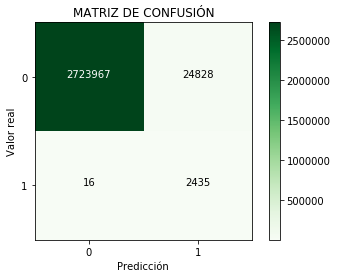

In [142]:
matconf = confusion_matrix(y_test_completo, y_pred_test_completo)
matriz_confusion(matconf)
plt.show()

#### Curva ROC

In [146]:
y_roc_test_completo = gradboostfit.predict_proba(X_test_completo)[:,1]
fpr_test_completo, tpr_test_completo, thresholds_test_completo = roc_curve(y_test_completo,y_roc_test_completo)
roc_auc_test_completo = auc(fpr_test_completo,tpr_test_completo)


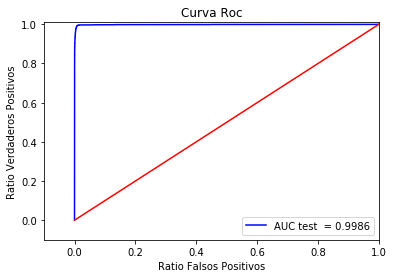

In [147]:
plt.title('Curva Roc')
plt.plot(fpr_test_completo, tpr_test_completo, 'b',label='AUC test  = '+str('%0.4f'%roc_auc_test_completo))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r-')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('Ratio Verdaderos Positivos')
plt.xlabel('Ratio Falsos Positivos')
plt.show()

#### Importancia de variables

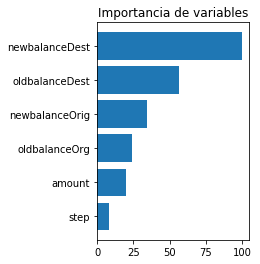

In [182]:
feature_importance = gradboostfit.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns)
plt.title('Importancia de variables')
plt.show()

#### Todos los estadísticos

In [148]:
#Recall
recall_test_completo = recall_score(y_test_completo,y_pred_test_completo)
#Precision        
precision_test_completo = precision_score(y_test_completo, y_pred_test_completo)
#Accuracy
accuracy_test_completo = accuracy_score(y_test_completo, y_pred_test_completo)
#AUC
roc_auc_test_completo = auc(fpr_test_completo,tpr_test_completo)

In [161]:
resultados_completo = pd.DataFrame(columns = ['Recall', 'Precision','Accuracy','Auc'])
resultados_completo.loc[0,'Recall'] = recall_test_completo
resultados_completo.loc[0,'Precision'] = precision_test_completo
resultados_completo.loc[0,'Accuracy'] = accuracy_test_completo
resultados_completo.loc[0,'Auc'] = roc_auc_test_completo

In [154]:
recall_test_completo

0.9934720522235823

In [162]:
resultados_completo

Recall  Precision Accuracy       Auc
0  0.993472  0.0893152  0.99097  0.998594

#### Con todo esto podemos concluir que pese a que los datos iniciales tenían muy poca proporción de fraude, se han obtenidos buenos resultados para el modelo. 